In [1]:
%load_ext autoreload
%autoreload 2

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, you will code a naive actor-critic algorithm in the tabular case. Then you will tune it using grid search and Bayesian optimization, potentially using the [optuna](https://optuna.readthedocs.io/en/stable/) library.
Finally, you will get the best hyper-parameters obtained with both methods and perform a statistical test to see if there is a statistically significant difference between these methods and with respect to naive hyper-parameter values.

## Install libraries

In [2]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [3]:
import torch
import torch.nn as nn

In [4]:
import gymnasium as gym

from bbrl.utils.chrono import Chrono

import matplotlib
import matplotlib.pyplot as plt

from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial
import tools 
matplotlib.use("TkAgg")

Matplotlib backend: module://matplotlib_inline.backend_inline


# Step 1: Coding the naive Actor-critic algorithm

We consider the naive actor-critic algorithm with a categorical policy.
The algorithm learns a critic with the standard temporal difference mechanism
using a learning rate $\alpha_{critic}$.

We consider a value-based critic $V(s)$. The extension to an action value function $Q(s,a)$ is straightforward.

To update the critic, the algorithm computes the temporal difference error:

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1})-V^{(n)}(s_t).$$

Then it applies it to the critic:

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

To update the actor, the general idea is the same, using the temporal difference error with another learning rate $\alpha_{actor}$.

However, naively applying the same learning rule would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative, it may happen that the probability of an action gets negative or null, which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## Exercise 1

### 1. Code the naive actor-critic algorithm as specified above.

Some hints:

- a good idea to build this code it to take inspiration from the code of Q-learning, to add an actor (a categorical policy), both learning rates,
and to take care about the renormalization function.

- for the next steps of this lab, having a function to repeatedly call your actor-critic algorithm and save the learning trajectories and
norms of the value function is a good idea.

In [5]:
import gymnasium as gym

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)
env.reset()
env.unwrapped.init_draw("The maze")

       [ 1,  3,  6,  8],
       [-1,  4,  7,  9]]), t…

In [6]:
def naive_actor_critic(
    env: MazeMDPEnv,
    alpha_actor: float,
    alpha_critic: float,
    gamma: float,
    nb_episodes: int = 1000,
    timeout: int = 50,
    render: bool = False,
):
    """
    Naive actor-critic algorithm
    Args:
        env: The environment
        alpha_actor: Learning rate for the actor
        alpha_critic: Learning rate for the critic
        gamma: Discount factor
        nb_episodes: Number of episodes
        timeout: Maximum number of steps per episode
        render: Boolean flag to render the environment
    Returns:
        policy, value_function, trajectories
    """
    # Initialize value function V(s) and the policy pi(a|s)
    V = np.zeros(env.nb_states)  # Critic (value function V(s))
    pi = np.ones((env.nb_states, env.action_space.n)) / env.action_space.n  # Actor (policy pi(a|s))

    # Function to renormalize the policy for a given state
    def renormalize_policy(pi, s):
        pi[s, :] = pi[s, :] / np.sum(pi[s, :])

    trajectories = []

    for episode in range(nb_episodes):
        s, _ = env.reset(uniform=True)
        cpt = 0
        terminated = False
        truncated = False

        while not (terminated or truncated) and cpt < timeout:
            if render:
                env.draw_v_pi(V, pi.argmax(axis=1))

            # Sample an action from the current policy pi(a|s)
            a = sample_categorical(pi[s, :])

            # Perform a step in the environment
            s_next, r, terminated, truncated, _ = env.step(a)

            # Calculate the temporal difference error (TD error)
            delta = r + gamma * V[s_next] * (1 - terminated) - V[s]

            # Update the critic (value function)
            V[s] = V[s] + alpha_critic * delta

            # Update the actor (policy) for the action taken
            pi_temp = pi[s, a] + alpha_actor * delta
            pi_temp = max(pi_temp, 1e-8)  # Ensure non-negative probability

            # Apply renormalization to ensure sum of probabilities is 1
            pi[s, a] = pi_temp
            renormalize_policy(pi, s)

            # Move to the next state
            s = s_next
            cpt += 1

        trajectories.append(cpt)

    return pi, V, trajectories



### 2. Provide a plot function

Your plot function should show the evolution through time of number of steps the agent takes to find the reward in the maze.
If your algorithm works, this number of steps should decrease through time.

Your plot function should also show a mean and a standard deviation (or some more advanced statistics) over a collection of learning runs.

In [7]:
def run_multiple_experiments(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, n_runs):
    """
    Runs the naive actor-critic algorithm multiple times and returns the results.

    Args:
        env: The environment.
        alpha_actor: Learning rate for the actor.
        alpha_critic: Learning rate for the critic.
        nb_episodes: Number of episodes for each run.
        timeout: Maximum number of steps per episode.
        n_runs: Number of independent runs.

    Returns:
        all_trajectories: A 2D array where each row corresponds to the number of steps in each episode for a single run.
    """
    all_trajectories = []

    for _ in range(n_runs):
        _, _, trajectories = naive_actor_critic(
            env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=False
        )
        all_trajectories.append(trajectories)

    return np.array(all_trajectories)


def plot_learning_curve(all_trajectories):
    """
    Plots the learning curve showing the evolution of the number of steps the agent takes to find the goal.
    Also plots the mean and standard deviation across multiple runs.

    Args:
        all_trajectories: A 2D array where each row corresponds to the number of steps in each episode for a single run.
    """
    # Calculate mean and standard deviation across runs
    mean_steps = np.mean(all_trajectories, axis=0)
    std_steps = np.std(all_trajectories, axis=0)

    # Plot the mean and standard deviation
    plt.figure(figsize=(10, 6))
    plt.plot(mean_steps, label='Mean number of steps')
    plt.fill_between(range(len(mean_steps)), mean_steps - std_steps, mean_steps + std_steps, alpha=0.3, label='Std deviation')

    plt.xlabel('Episodes')
    plt.ylabel('Number of steps to reach goal')
    plt.title('Learning Curve: Evolution of Steps to Reach Goal')
    plt.legend()
    plt.grid(True)
    plt.show()


## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

In [8]:
ac_params = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "rgb_array", #human - to render the maze or 
        },
        
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 100,
    "timeout": 200,
    "render": True, 
    "nb_repeats": 5,

    "gamma": 0.99,
    
    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

In [9]:
def create_maze_from_params(ac_params):
    """
    Creates a maze environment using parameters from ac_params.
    
    Args:
        ac_params: Dictionary containing all relevant parameters for the maze environment.
    
    Returns:
        env: The initialized maze environment.
    """
    env_params = ac_params['mdp']

    env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": env_params['width'], "height": env_params['height'], "ratio": env_params['ratio'], "hit": 0.0},
    render_mode=env_params['render_mode'],
)
    env.reset()
    #env.unwrapped.init_draw("The maze")
    return env

### 3. Test your code

Once everything looks OK, save the obtained plot for your lab report

In [10]:
env = tools.create_maze_from_params(ac_params)

alpha_actor = ac_params['alpha_actor']
alpha_critic = ac_params['alpha_critic']
gamma = ac_params['alpha_critic'] 
nb_episodes = ac_params['nb_episodes']
timeout = ac_params['timeout']
n_runs = ac_params['nb_repeats']  

In [11]:
_, _, trajectories = naive_actor_critic(
            env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=False
        )

/home/neil/deepdac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nb_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nb_states` for environment variables or `env.get_wrapper_attr('nb_states')` that will search the reminding wrappers.
  logger.warn(


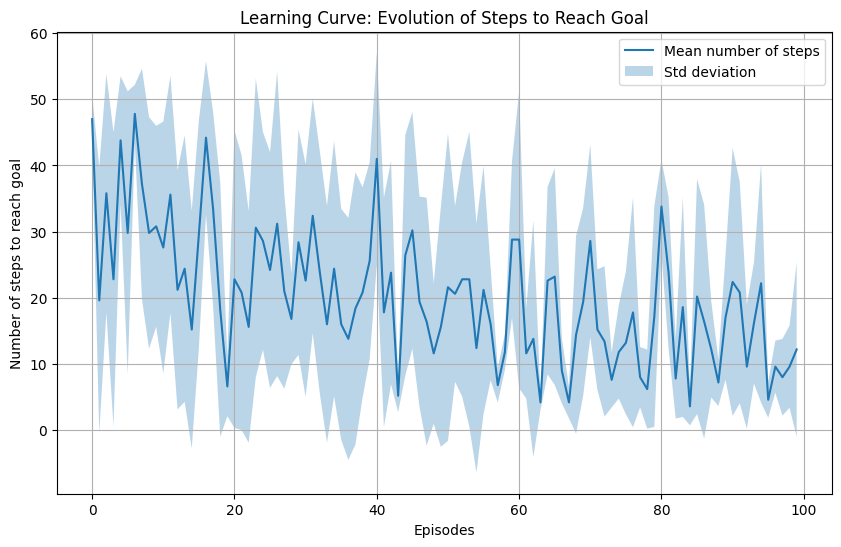

In [12]:
%matplotlib inline
# Run multiple experiments and gather results using parameters from the dictionary
all_trajectories = run_multiple_experiments(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, n_runs)

# Plot the learning curve with mean and standard deviation
plot_learning_curve(all_trajectories)

# Step 2: Tuning hyper-parameters

In this part, you have to optimize two hyper-parameters of the actor-critic algorithm, namely the actor and critic learning rates.
You have to do so using a simple grid search method and some Bayesian optimization method.
For the latter, we suggest using the default sampler from [optuna](https://optuna.readthedocs.io/en/stable/).
Follow the above link to understand how optuna works.
Note that it also supports grid search and many other hyper-parameters tuning algorithms.

You should make sure that the hyper-parameters tuning algorithms that you compare benefit from the same training budget
We suggest 400 training runs overall for each method,
which means 20 values each for the actor and the critic learning rates in the case of grid search.

## Exercise 2

### 1. Perform hyper-parameters tuning with two algorithms as suggested above.

### 2. Provide a "heatmap" of the norm of the value function given the hyper-parameters, after training for each pair of hyper-parameters.

### 3. Collect the value of the best hyper-parameters found with each algorithm. You will need them for Step 3.

### 4. Include in your report the heatmaps and the best hyper-parameters found for each method.

# Hyper-parameters tuning

In [24]:
# Importer les fonctions nécessaires depuis le fichier tools.py
from tools import run_optimization, objective_cumulative_reward, objective_discounted_reward, objective_td_error, objective_policy_entropy


In [57]:
ac_params = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "rgb_array", #human - to render the maze or 
        },
        
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 100,
    "timeout": 200,
    "render": False, 
    "nb_repeats": 5,

    "gamma": 0.9,
    
    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

# Liste des fonctions objectives possibles pour objective_fn dans run_optimization :
# 1. objective_cumulative_reward : Optimise la récompense cumulative.
# 2. objective_discounted_reward : Optimise la récompense cumulative actualisée (avec le facteur d'actualisation gamma).
# 3. objective_td_error : Optimise l'erreur de différence temporelle (TD error).
# 4. objective_policy_entropy : Optimise l'entropie de la politique (pour encourager l'exploration).

# Example usage: Run Bayesian optimization with 100 trials and default TPESampler (Bayesian optimization)
study, best_params, best_performance, all_params, all_performances, value_norms, learning_curves_dict = tools.run_optimization(ac_params, n_trials=100, objective_fn=objective_policy_entropy)

# Print results
print("Best Hyperparameters found by Optuna:")
print(best_params)
print(f"Best Performance (norm of value function): {best_performance}")


[I 2024-09-29 14:58:56,914] A new study created in memory with name: no-name-8195e6be-d941-47cb-87c8-2508854631a5


Sampler is TPESampler


[I 2024-09-29 14:58:57,279] Trial 0 finished with value: 1.3862942936250455 and parameters: {'alpha_actor': 4.1972388987010826e-05, 'alpha_critic': 0.3665085456264724}. Best is trial 0 with value: 1.3862942936250455.
[I 2024-09-29 14:58:57,621] Trial 1 finished with value: 1.3847858839331129 and parameters: {'alpha_actor': 0.03101823133262594, 'alpha_critic': 0.0077018280026698}. Best is trial 1 with value: 1.3847858839331129.
[I 2024-09-29 14:58:57,986] Trial 2 finished with value: 1.3860461415922987 and parameters: {'alpha_actor': 0.013883038574678225, 'alpha_critic': 0.0028620336456757914}. Best is trial 1 with value: 1.3847858839331129.
[I 2024-09-29 14:58:58,355] Trial 3 finished with value: 1.3861334937663374 and parameters: {'alpha_actor': 0.006012354111070164, 'alpha_critic': 0.047467947102808154}. Best is trial 1 with value: 1.3847858839331129.
[I 2024-09-29 14:58:58,743] Trial 4 finished with value: 1.3862943204119742 and parameters: {'alpha_actor': 1.5740116732447e-05, 'alph

Best Hyperparameters found by Optuna:
{'alpha_actor': 0.9860789775062142, 'alpha_critic': 0.3465243794757216}
Best Performance (norm of value function): 0.6440216518081584


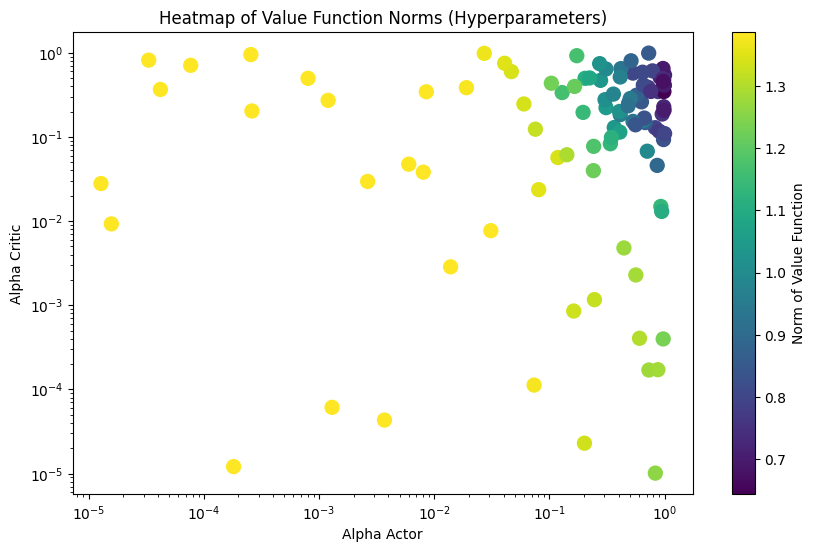

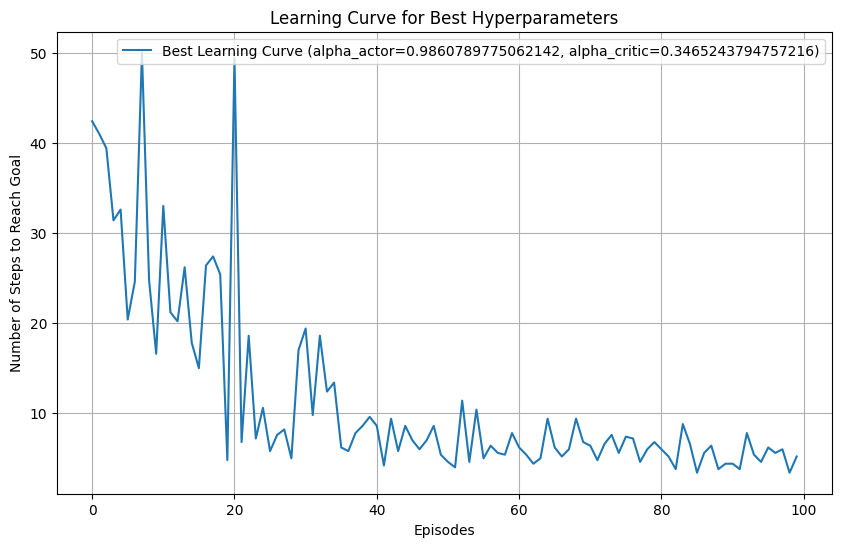

In [58]:
# Assuming best_params, learning_curves_dict, and study are obtained from the previous steps
%matplotlib inline
# Plot the heatmap of the optimization results
tools.plot_heatmap_from_study(study)

# Plot the learning curve for the best hyperparameters
tools.plot_learning_curve(learning_curves_dict, best_params)

/tmp/ipykernel_3810/335677412.py:18: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  "Gaussian Process": GPSampler(),
/tmp/ipykernel_3810/335677412.py:20: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  "Quasi Monte Carlo (QMC)": QMCSampler(),
[I 2024-09-29 14:04:14,725] A new study created in memory with name: no-name-357bdeff-89af-499a-82e3-0a54cd4f9d1b



Running optimization using Grid Search...
Sampler is GridSampler


[I 2024-09-29 14:04:15,008] Trial 0 finished with value: -0.000411910657395757 and parameters: {'alpha_actor': 0.00017782794100389227, 'alpha_critic': 1e-05}. Best is trial 0 with value: -0.000411910657395757.
[I 2024-09-29 14:04:15,283] Trial 1 finished with value: -0.11687538089539151 and parameters: {'alpha_actor': 1e-05, 'alpha_critic': 0.0031622776601683794}. Best is trial 1 with value: -0.11687538089539151.
[I 2024-09-29 14:04:15,482] Trial 2 finished with value: -2.513272315922205 and parameters: {'alpha_actor': 0.05623413251903491, 'alpha_critic': 1.0}. Best is trial 2 with value: -2.513272315922205.
[I 2024-09-29 14:04:15,767] Trial 3 finished with value: -0.007228349260974579 and parameters: {'alpha_actor': 0.05623413251903491, 'alpha_critic': 0.00017782794100389227}. Best is trial 2 with value: -2.513272315922205.
[I 2024-09-29 14:04:16,044] Trial 4 finished with value: -0.007863219217556092 and parameters: {'alpha_actor': 0.0031622776601683794, 'alpha_critic': 0.00017782794


Running optimization using Random Search...
Sampler is RandomSampler


[I 2024-09-29 14:04:21,922] Trial 0 finished with value: -0.1298534811069539 and parameters: {'alpha_actor': 0.49680360543453705, 'alpha_critic': 0.0033492058376712757}. Best is trial 0 with value: -0.1298534811069539.
[I 2024-09-29 14:04:22,184] Trial 1 finished with value: -0.11719918164542462 and parameters: {'alpha_actor': 0.9507298976758796, 'alpha_critic': 0.0025258881645094846}. Best is trial 0 with value: -0.1298534811069539.
[I 2024-09-29 14:04:22,470] Trial 2 finished with value: -0.05358809035153299 and parameters: {'alpha_actor': 0.26527204124570875, 'alpha_critic': 0.0012463580716072593}. Best is trial 0 with value: -0.1298534811069539.
[I 2024-09-29 14:04:22,733] Trial 3 finished with value: -0.443000448180487 and parameters: {'alpha_actor': 0.11052128726236363, 'alpha_critic': 0.012270210020040646}. Best is trial 3 with value: -0.443000448180487.
[I 2024-09-29 14:04:23,017] Trial 4 finished with value: -1.396867809498639 and parameters: {'alpha_actor': 0.0010480752851514


Running optimization using TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-09-29 14:04:49,831] Trial 0 finished with value: -0.0006918398093681269 and parameters: {'alpha_actor': 0.0002761452528130899, 'alpha_critic': 1.9119005959178048e-05}. Best is trial 0 with value: -0.0006918398093681269.
[I 2024-09-29 14:04:50,110] Trial 1 finished with value: -1.4560124289593195 and parameters: {'alpha_actor': 0.000670121638811752, 'alpha_critic': 0.4529038255381078}. Best is trial 1 with value: -1.4560124289593195.
[I 2024-09-29 14:04:50,248] Trial 2 finished with value: -2.0578565859268765 and parameters: {'alpha_actor': 0.4468746414691994, 'alpha_critic': 0.11532277659434789}. Best is trial 2 with value: -2.0578565859268765.
[I 2024-09-29 14:04:50,411] Trial 3 finished with value: -2.4805993658606726 and parameters: {'alpha_actor': 0.15655649242919237, 'alpha_critic': 0.3148381733743815}. Best is trial 3 with value: -2.4805993658606726.
[I 2024-09-29 14:04:50,698] Trial 4 finished with value: -0.5657033724653096 and parameters: {'alpha_actor': 0.002941870503


Running optimization using Gaussian Process...
Sampler is GPSampler


[I 2024-09-29 14:05:09,282] Trial 0 finished with value: -0.007301895666015033 and parameters: {'alpha_actor': 8.241573775512936e-05, 'alpha_critic': 0.00016657081402043854}. Best is trial 0 with value: -0.007301895666015033.
[I 2024-09-29 14:05:09,562] Trial 1 finished with value: -0.000862809342956233 and parameters: {'alpha_actor': 7.576711366225206e-05, 'alpha_critic': 1.8365777837372093e-05}. Best is trial 0 with value: -0.007301895666015033.
[I 2024-09-29 14:05:09,833] Trial 2 finished with value: -0.0009303833078099079 and parameters: {'alpha_actor': 0.0037215156424774704, 'alpha_critic': 2.1447385467966055e-05}. Best is trial 0 with value: -0.007301895666015033.
[I 2024-09-29 14:05:10,130] Trial 3 finished with value: -0.028580651762943277 and parameters: {'alpha_actor': 0.06874387445952429, 'alpha_critic': 0.0007219327855974339}. Best is trial 3 with value: -0.028580651762943277.
[I 2024-09-29 14:05:10,424] Trial 4 finished with value: -0.0013736788666727276 and parameters: {'


Running optimization using NSGA-II...
Sampler is NSGAIISampler


[I 2024-09-29 14:05:42,180] Trial 0 finished with value: -0.006651463723284586 and parameters: {'alpha_actor': 0.5195037034392128, 'alpha_critic': 0.0001651789554057993}. Best is trial 0 with value: -0.006651463723284586.
[I 2024-09-29 14:05:42,481] Trial 1 finished with value: -1.2452105248612217 and parameters: {'alpha_actor': 0.00016075380494686247, 'alpha_critic': 0.14479366560313156}. Best is trial 1 with value: -1.2452105248612217.
[I 2024-09-29 14:05:42,693] Trial 2 finished with value: -1.4884596842726912 and parameters: {'alpha_actor': 0.28500477337429836, 'alpha_critic': 0.06595766655002115}. Best is trial 2 with value: -1.4884596842726912.
[I 2024-09-29 14:05:42,991] Trial 3 finished with value: -0.011433818849921442 and parameters: {'alpha_actor': 0.01685189248454002, 'alpha_critic': 0.00033049065111506336}. Best is trial 2 with value: -1.4884596842726912.
[I 2024-09-29 14:05:43,257] Trial 4 finished with value: -0.0008410702018183518 and parameters: {'alpha_actor': 0.00022


Running optimization using Quasi Monte Carlo (QMC)...
Sampler is QMCSampler


[I 2024-09-29 14:06:10,172] Trial 1 finished with value: -0.0007111400491865557 and parameters: {'alpha_actor': 0.011084448582090756, 'alpha_critic': 1.891991558072274e-05}. Best is trial 0 with value: -1.5883469960228367.
[I 2024-09-29 14:06:10,529] Trial 2 finished with value: -0.12000639256376862 and parameters: {'alpha_actor': 0.003162277660168379, 'alpha_critic': 0.003162277660168379}. Best is trial 0 with value: -1.5883469960228367.
[I 2024-09-29 14:06:10,842] Trial 3 finished with value: -0.005957558110661815 and parameters: {'alpha_actor': 0.056234132519034884, 'alpha_critic': 0.00017782794100389232}. Best is trial 0 with value: -1.5883469960228367.
[I 2024-09-29 14:06:11,119] Trial 4 finished with value: -1.0245002870630162 and parameters: {'alpha_actor': 0.00017782794100389232, 'alpha_critic': 0.056234132519034884}. Best is trial 0 with value: -1.5883469960228367.
[I 2024-09-29 14:06:11,399] Trial 5 finished with value: -0.030412294221522966 and parameters: {'alpha_actor': 0.

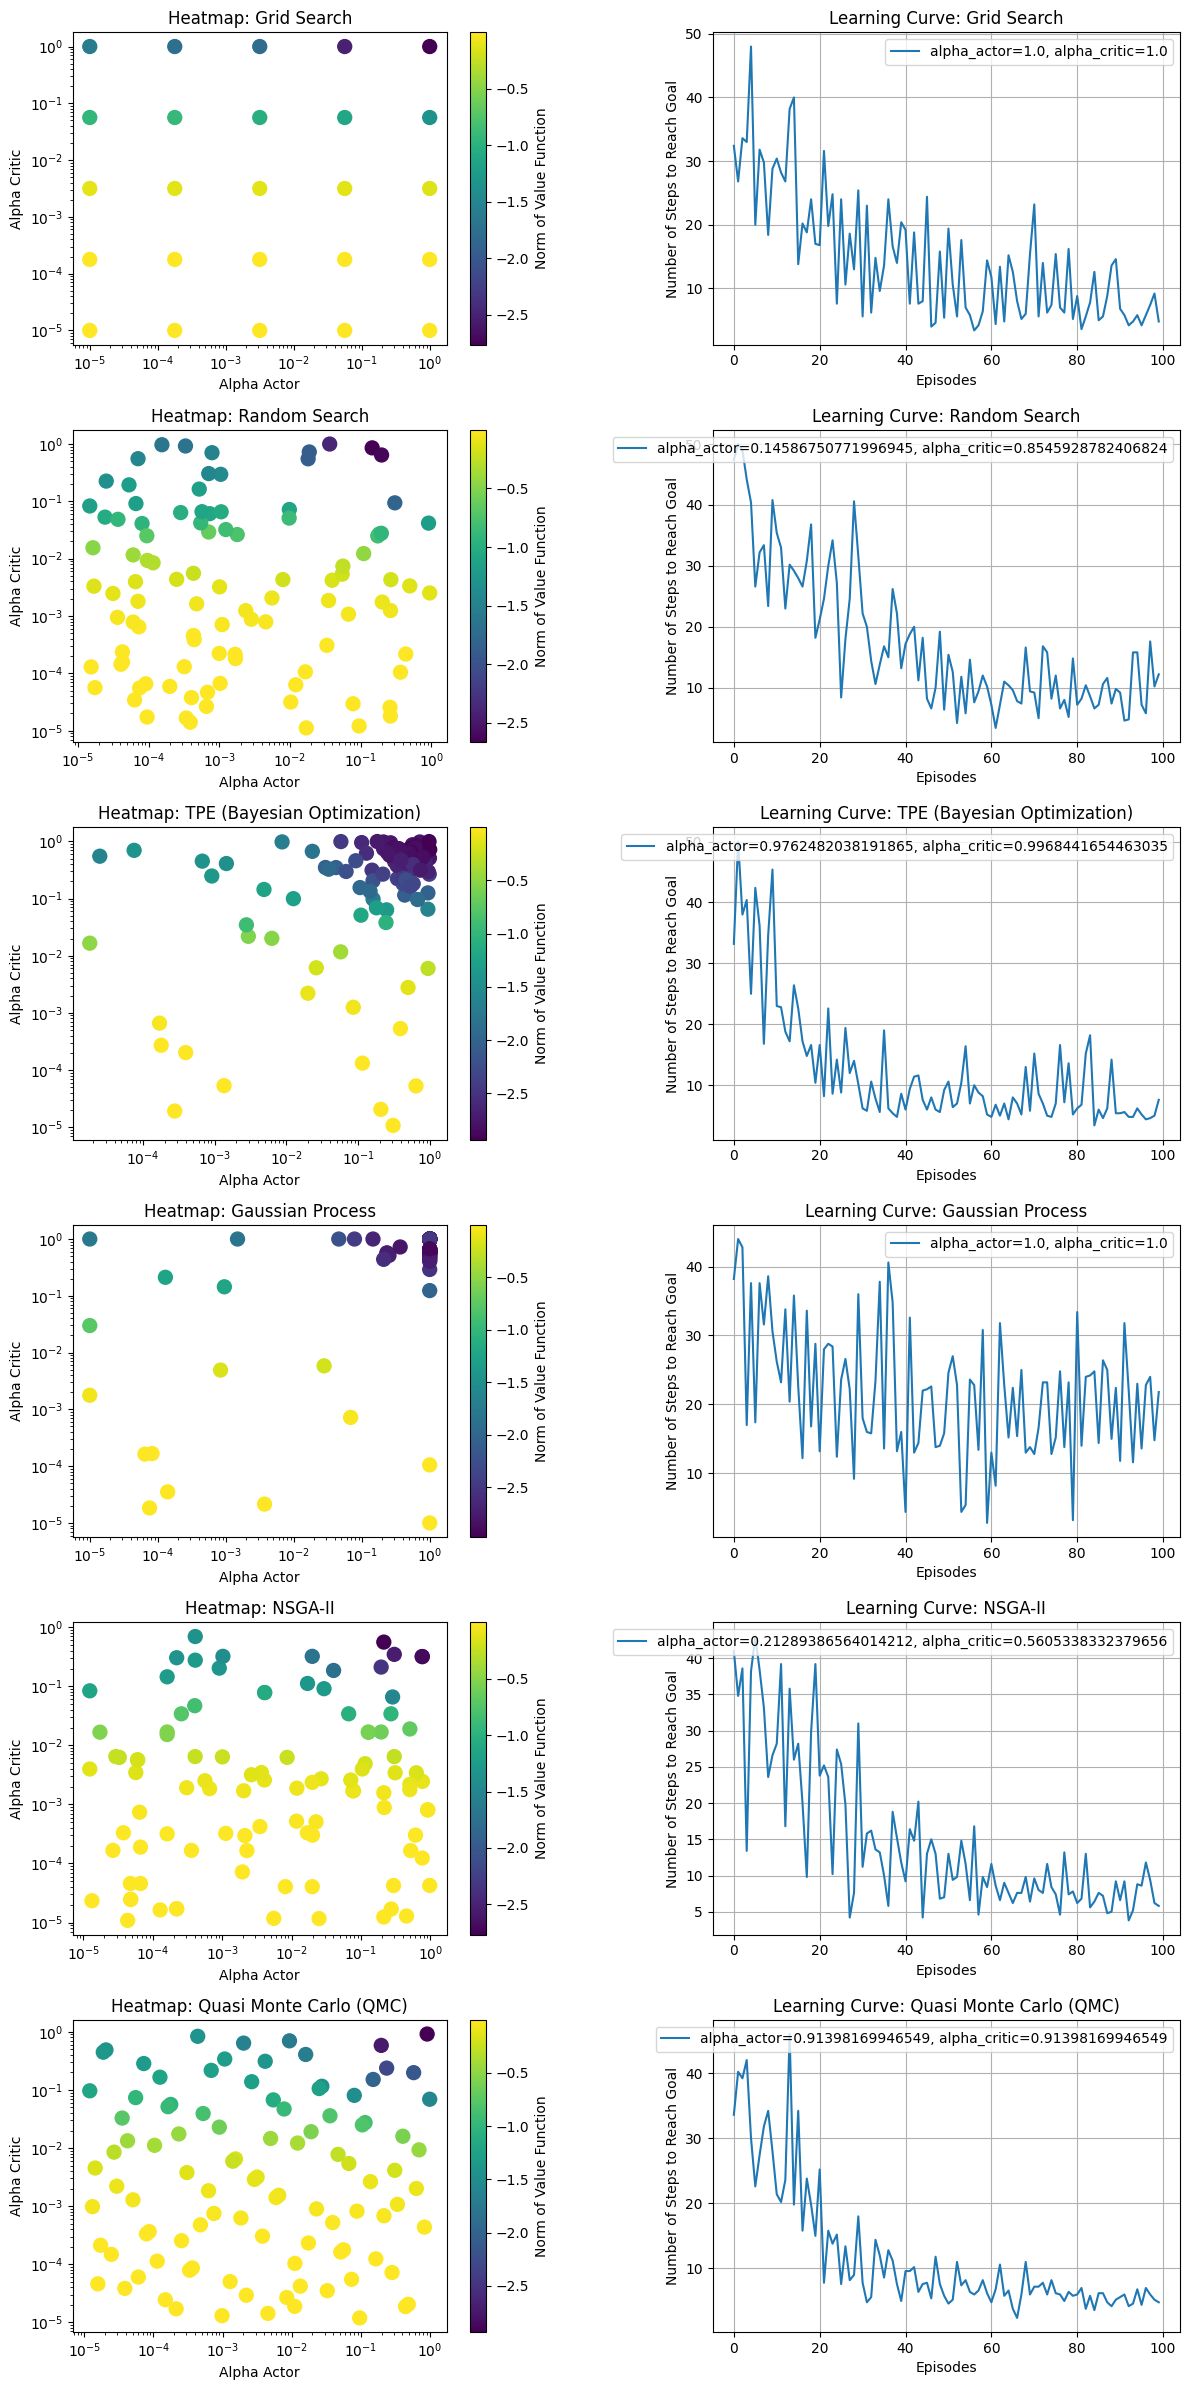


Best Hyperparameters for Each Sampler:
Grid Search: {'alpha_actor': 1.0, 'alpha_critic': 1.0}
Random Search: {'alpha_actor': 0.14586750771996945, 'alpha_critic': 0.8545928782406824}
TPE (Bayesian Optimization): {'alpha_actor': 0.9762482038191865, 'alpha_critic': 0.9968441654463035}
Gaussian Process: {'alpha_actor': 1.0, 'alpha_critic': 1.0}
NSGA-II: {'alpha_actor': 0.21289386564014212, 'alpha_critic': 0.5605338332379656}
Quasi Monte Carlo (QMC): {'alpha_actor': 0.91398169946549, 'alpha_critic': 0.91398169946549}


In [15]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
from optuna.samplers import GridSampler, RandomSampler, TPESampler, CmaEsSampler, GPSampler, PartialFixedSampler, NSGAIISampler, QMCSampler
from tools import run_optimization, plot_heatmap_from_study, plot_learning_curve

# Define the search space for GridSampler
search_space = {
    "alpha_actor": np.logspace(-5, 0, 5).tolist(),  # 5 values between 1e-5 and 1.0
    "alpha_critic": np.logspace(-5, 0, 5).tolist()  # 5 values between 1e-5 and 1.0
}

# List of samplers to evaluate
samplers = {
    "Grid Search": GridSampler(search_space),
    "Random Search": RandomSampler(),
    "TPE (Bayesian Optimization)": TPESampler(),
    "Gaussian Process": GPSampler(),
    "NSGA-II": NSGAIISampler(),
    "Quasi Monte Carlo (QMC)": QMCSampler(),
}

# Dictionary to store results
best_params_per_sampler = {}
learning_curves_per_sampler = {}

# Create subplots for both heatmaps and learning curves
fig, axs = plt.subplots(len(samplers), 2, figsize=(12, len(samplers) * 4))  # 2 columns: Heatmap and Learning curve

# Run optimization for each sampler and plot results
for i, (sampler_name, sampler) in enumerate(samplers.items()):
    print(f"\nRunning optimization using {sampler_name}...")

    # Run the optimization using the current sampler
    study, best_params, best_performance, all_params, all_performances, value_norms, learning_curves_dict = run_optimization(ac_params, n_trials=100, sampler=sampler)

    # Store best hyperparameters and learning curves
    best_params_per_sampler[sampler_name] = best_params
    learning_curves_per_sampler[sampler_name] = learning_curves_dict

    # Extract data for heatmap plotting
    actor_values = []
    critic_values = []
    norm_values = []
    
    for trial in study.trials:
        actor_values.append(trial.params['alpha_actor'])
        critic_values.append(trial.params['alpha_critic'])
        norm_values.append(trial.value)

    # Plot heatmap in the left column
    ax_heatmap = axs[i, 0]
    scatter = ax_heatmap.scatter(actor_values, critic_values, c=norm_values, cmap='viridis', s=100)
    ax_heatmap.set_xscale('log')
    ax_heatmap.set_yscale('log')
    ax_heatmap.set_xlabel('Alpha Actor')
    ax_heatmap.set_ylabel('Alpha Critic')
    ax_heatmap.set_title(f'Heatmap: {sampler_name}')
    fig.colorbar(scatter, ax=ax_heatmap, label='Norm of Value Function')

    # Plot the learning curve in the right column
    ax_curve = axs[i, 1]
    best_alpha_actor = best_params['alpha_actor']
    best_alpha_critic = best_params['alpha_critic']
    best_learning_curve = learning_curves_dict[(best_alpha_actor, best_alpha_critic)]
    
    ax_curve.plot(best_learning_curve, label=f'alpha_actor={best_alpha_actor}, alpha_critic={best_alpha_critic}')
    ax_curve.set_xlabel('Episodes')
    ax_curve.set_ylabel('Number of Steps to Reach Goal')
    ax_curve.set_title(f'Learning Curve: {sampler_name}')
    ax_curve.legend()
    ax_curve.grid(True)

# Adjust layout to prevent overlap and ensure the plots fit well
plt.tight_layout()

# Show all the plots
plt.show()

# Print best hyperparameters for all samplers
print("\nBest Hyperparameters for Each Sampler:")
for sampler_name, best_params in best_params_per_sampler.items():
    print(f"{sampler_name}: {best_params}")


# Step 3: Statistical tests

Now you have to compare the performance of the actor-critic algorithm tuned
with all the best hyper-parameters you found before, using statistical tests.

The functions below are provided to run Welch's T-test over learning curves.
They have been adapted from a github repository: https://github.com/flowersteam/rl_stats
You don't need to understand them in detail (though it is always a good idea to try to understand more code).

In [16]:
from scipy.stats import ttest_ind
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [17]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

In [18]:
def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

This last function was adapted for the lab.

In [19]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    # plt.show()


Relancement de Grid Search avec les meilleurs hyperparamètres...
Run 1/20 pour Grid Search
Run 2/20 pour Grid Search
Run 3/20 pour Grid Search
Run 4/20 pour Grid Search
Run 5/20 pour Grid Search
Run 6/20 pour Grid Search
Run 7/20 pour Grid Search
Run 8/20 pour Grid Search
Run 9/20 pour Grid Search
Run 10/20 pour Grid Search
Run 11/20 pour Grid Search
Run 12/20 pour Grid Search
Run 13/20 pour Grid Search
Run 14/20 pour Grid Search
Run 15/20 pour Grid Search
Run 16/20 pour Grid Search
Run 17/20 pour Grid Search
Run 18/20 pour Grid Search
Run 19/20 pour Grid Search
Run 20/20 pour Grid Search

Relancement de Random Search avec les meilleurs hyperparamètres...
Run 1/20 pour Random Search
Run 2/20 pour Random Search
Run 3/20 pour Random Search
Run 4/20 pour Random Search
Run 5/20 pour Random Search
Run 6/20 pour Random Search
Run 7/20 pour Random Search
Run 8/20 pour Random Search
Run 9/20 pour Random Search
Run 10/20 pour Random Search
Run 11/20 pour Random Search
Run 12/20 pour Random Sea

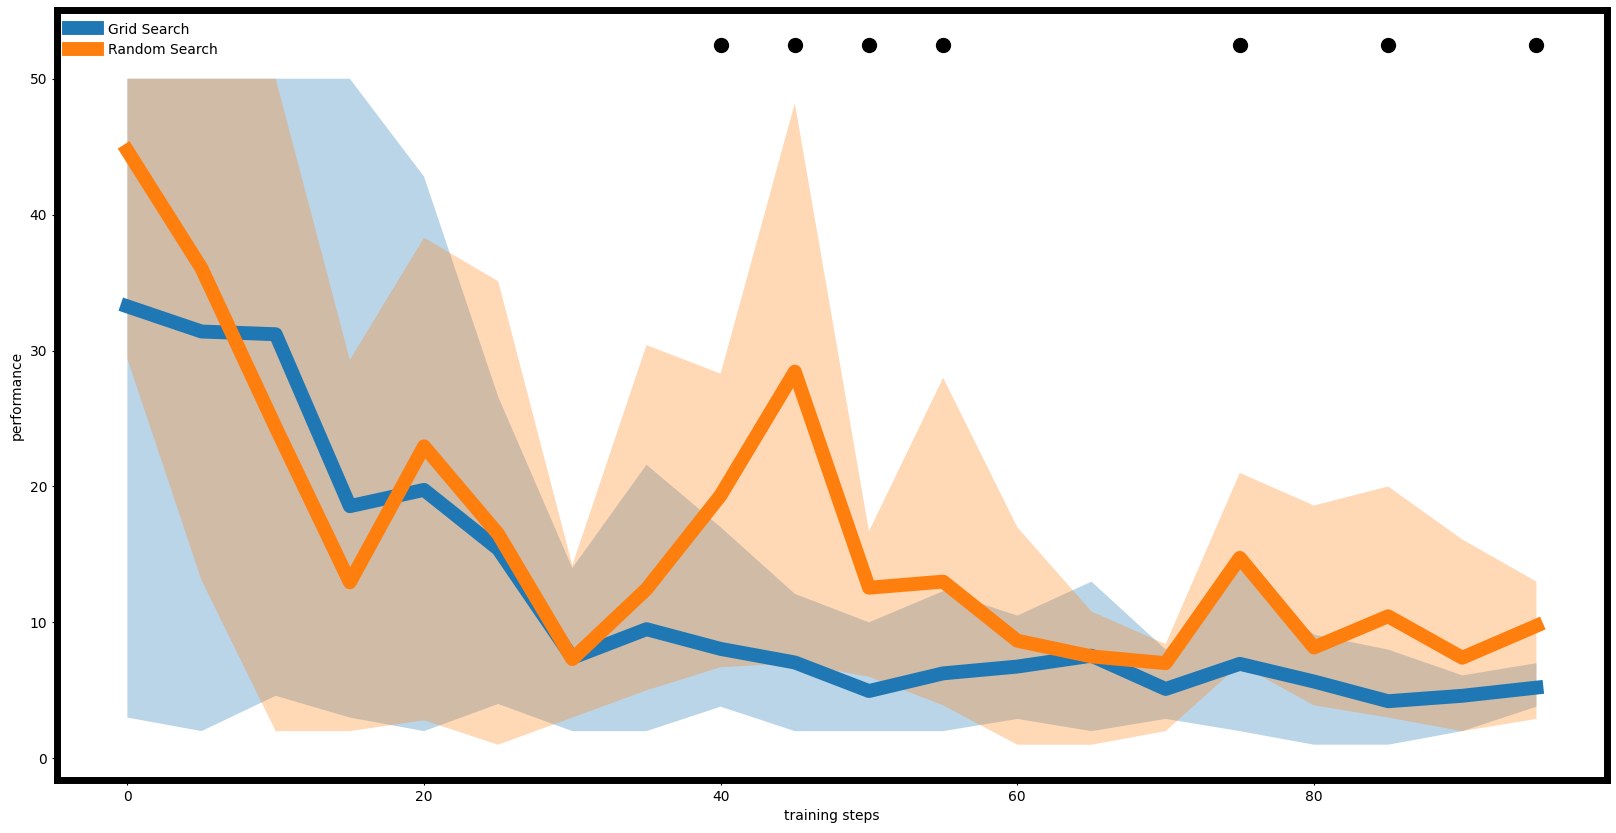

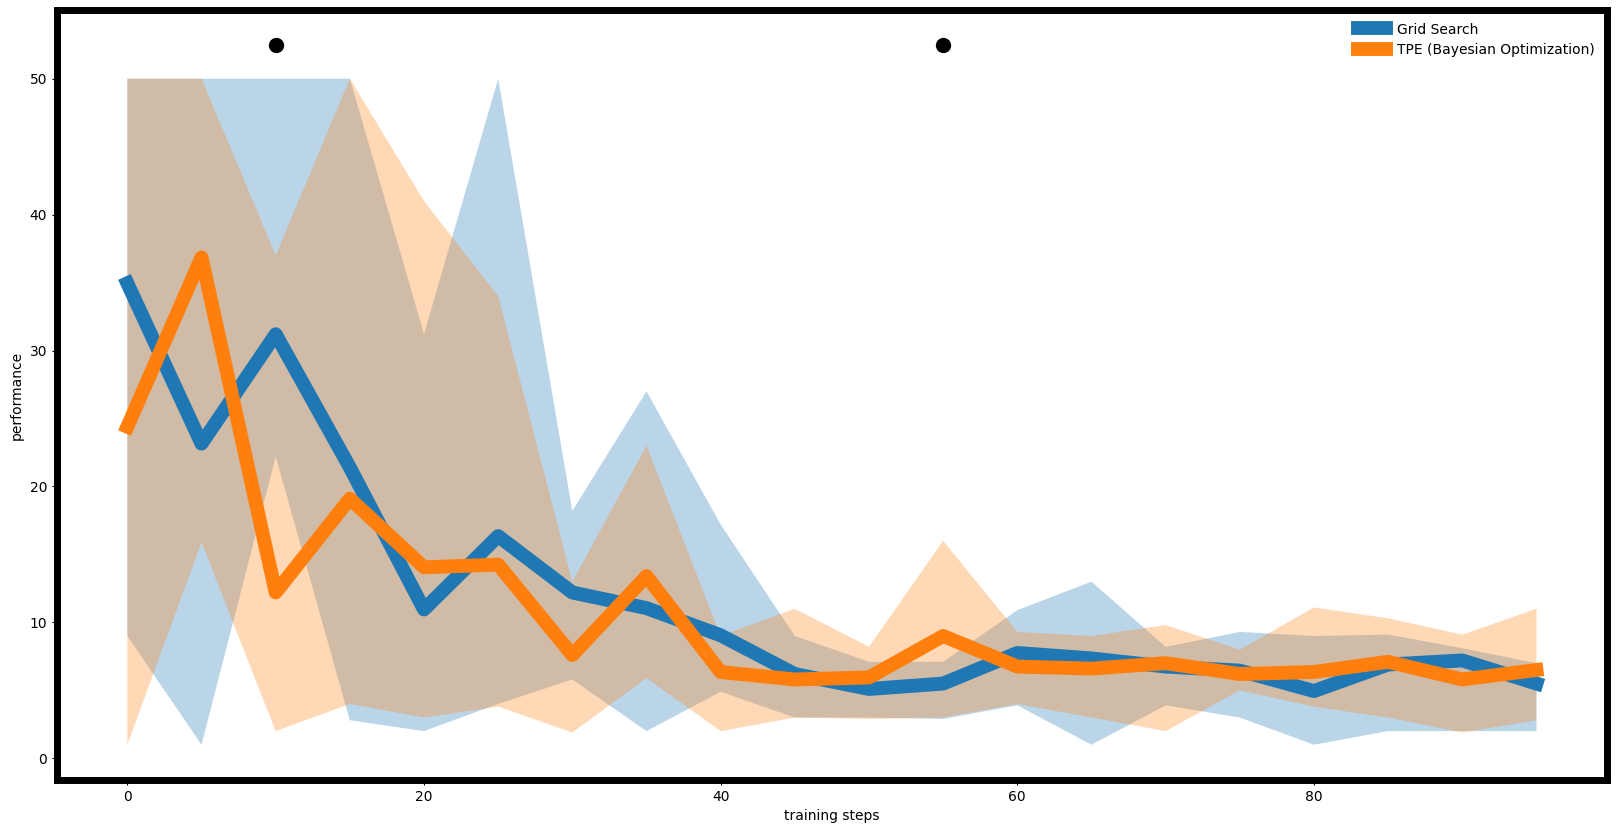

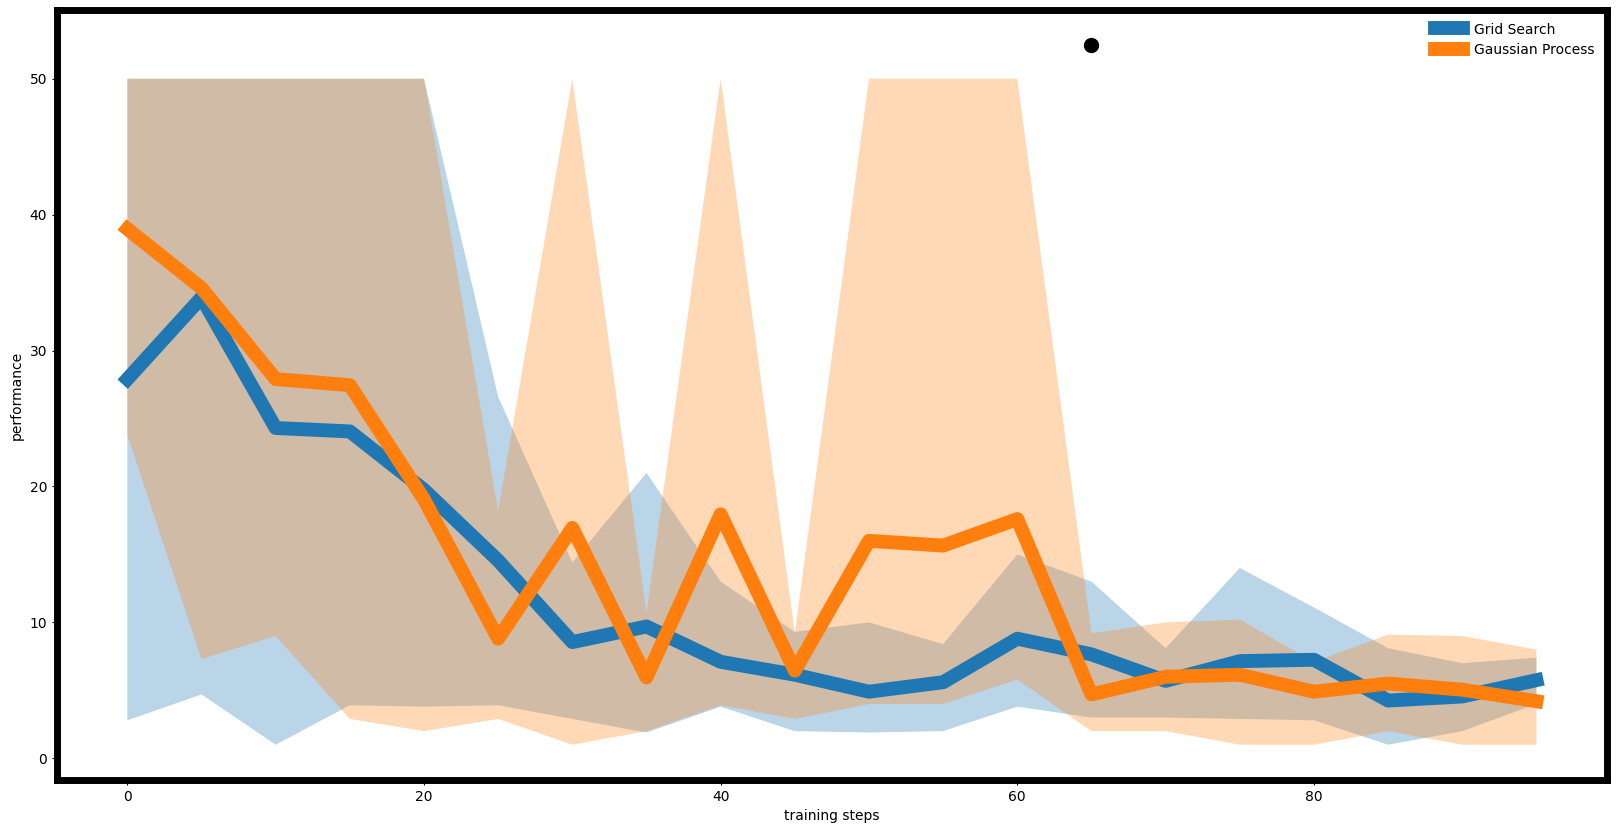

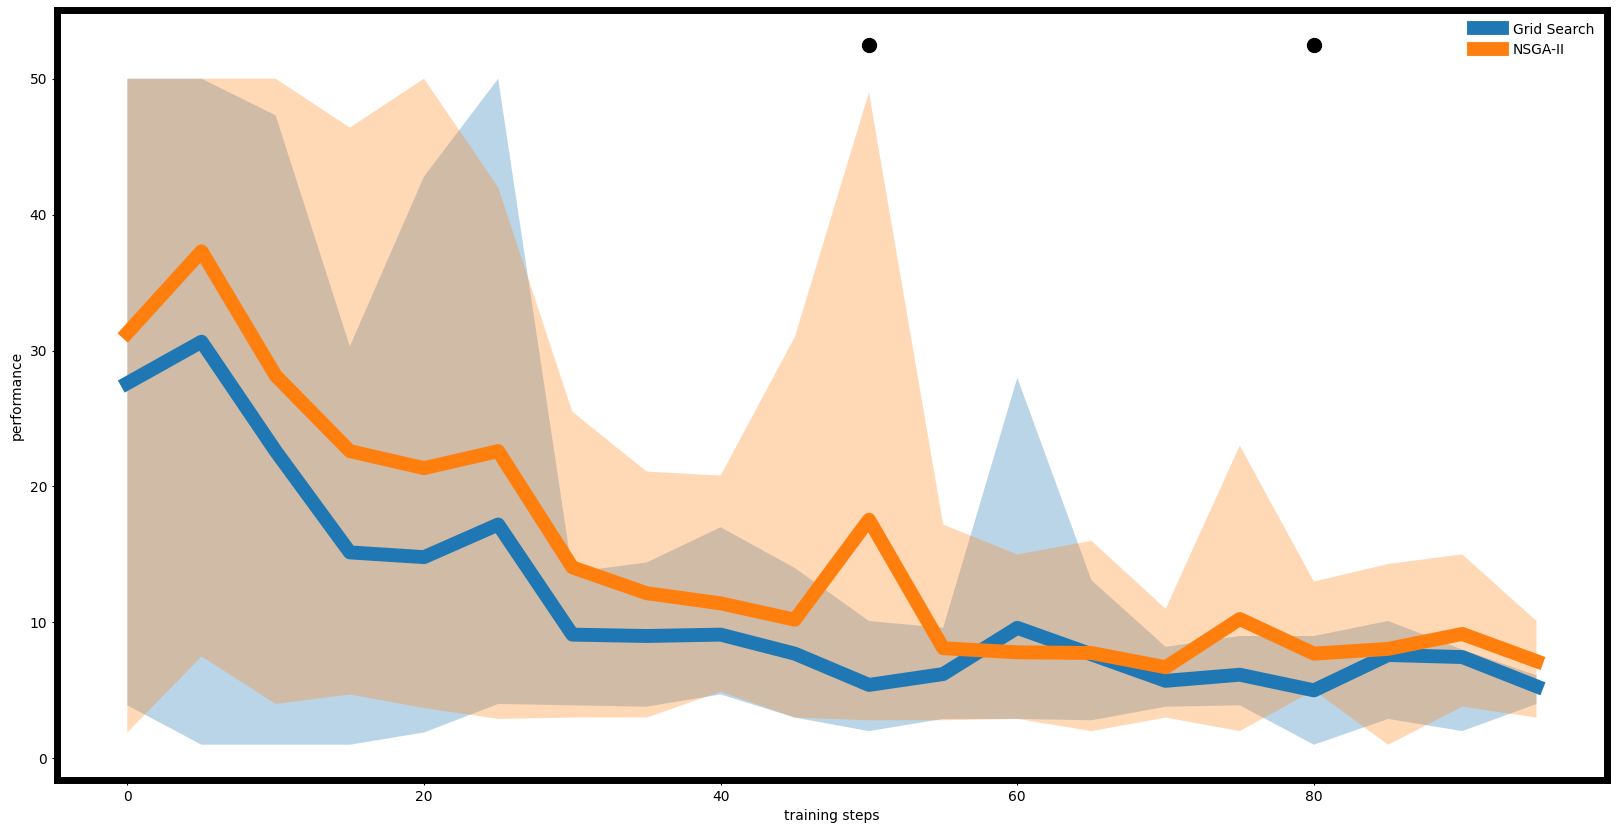

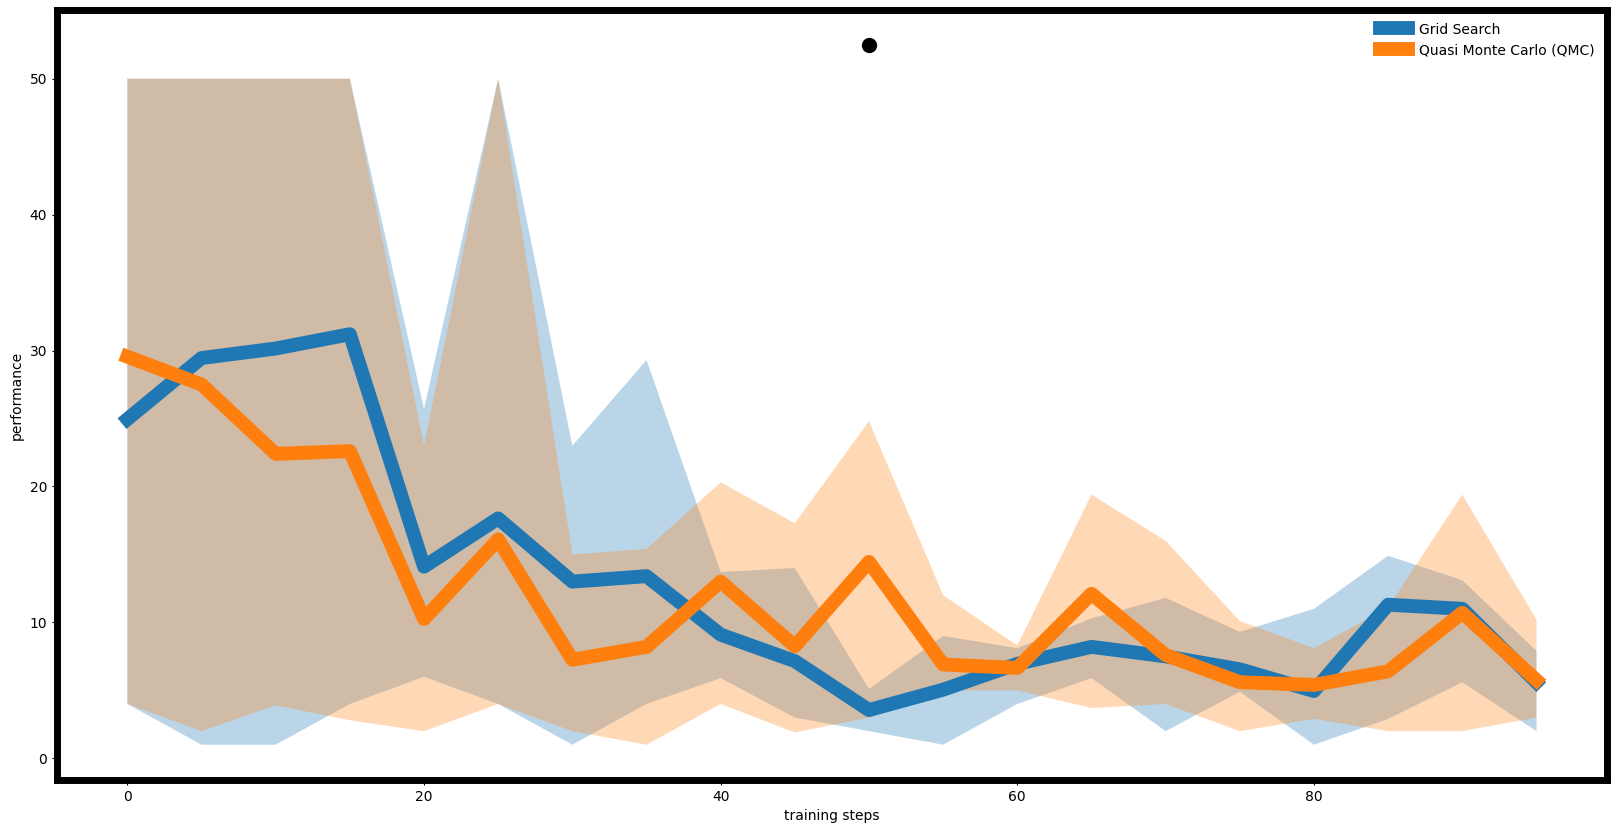

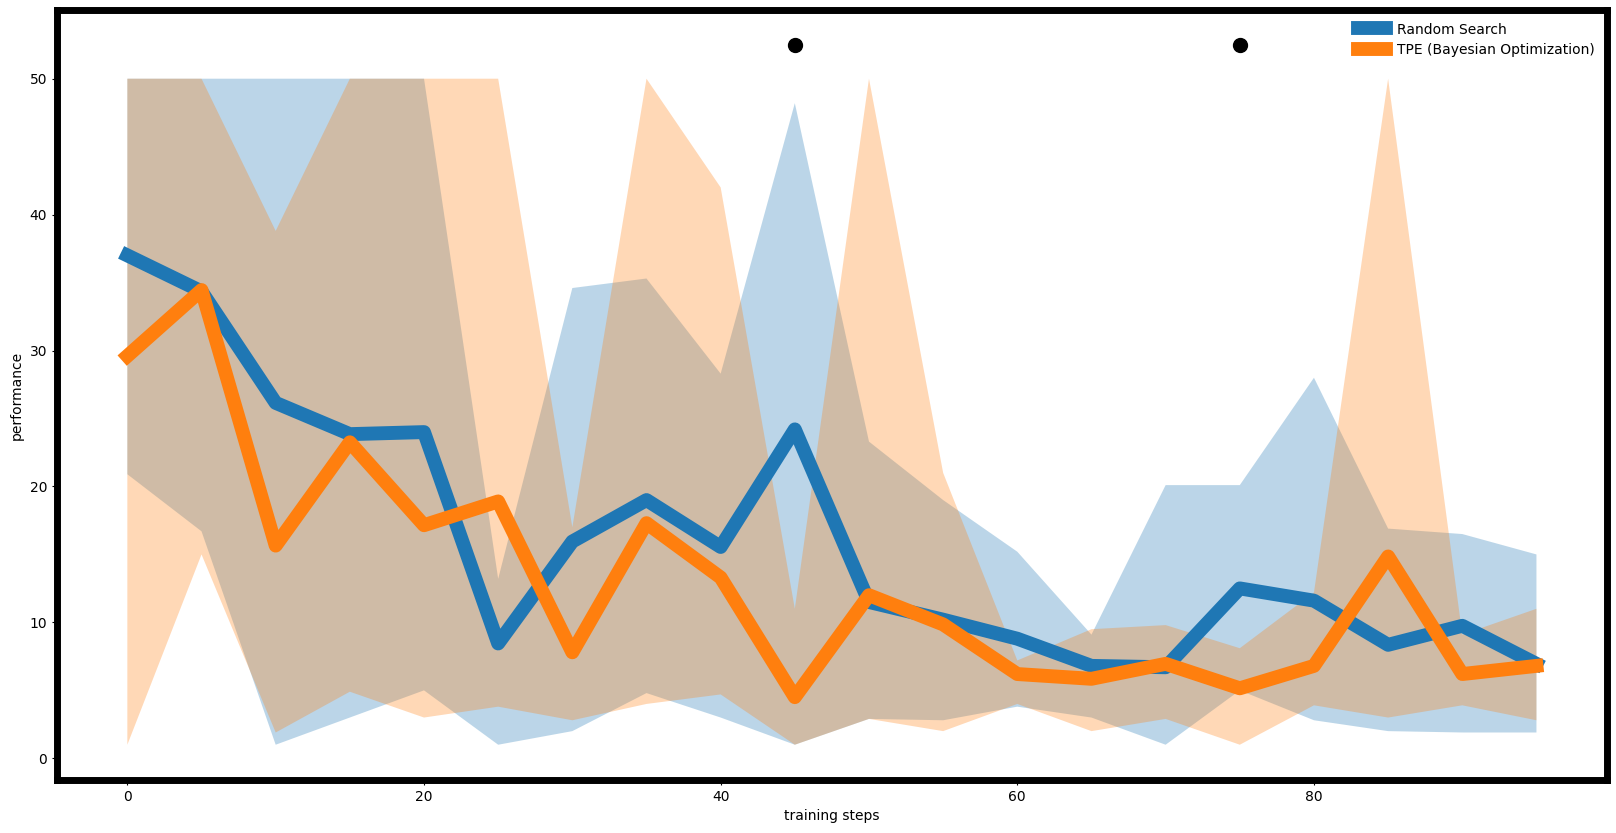

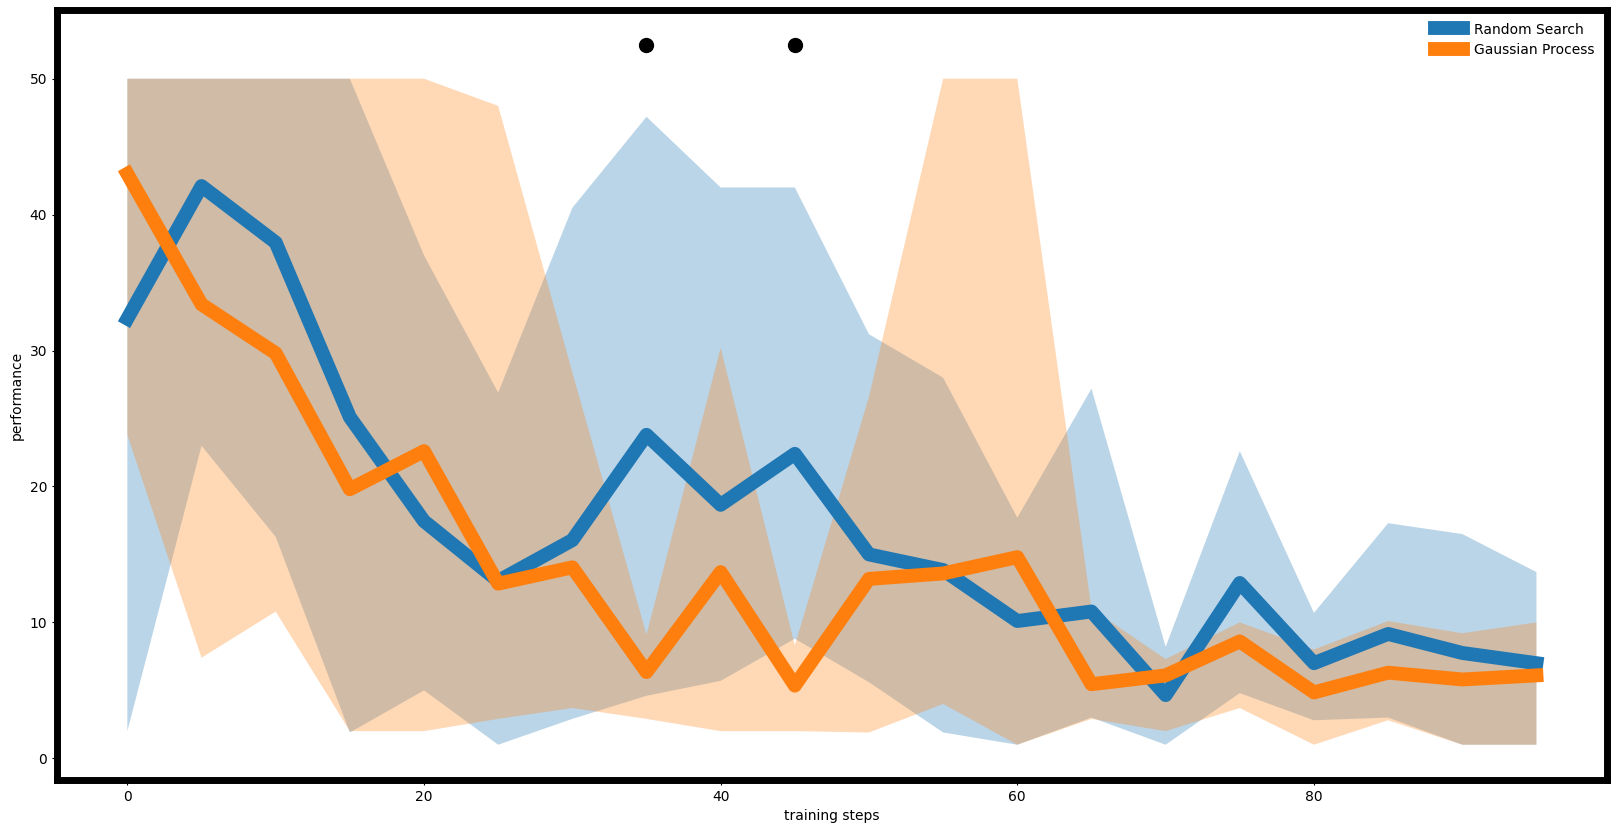

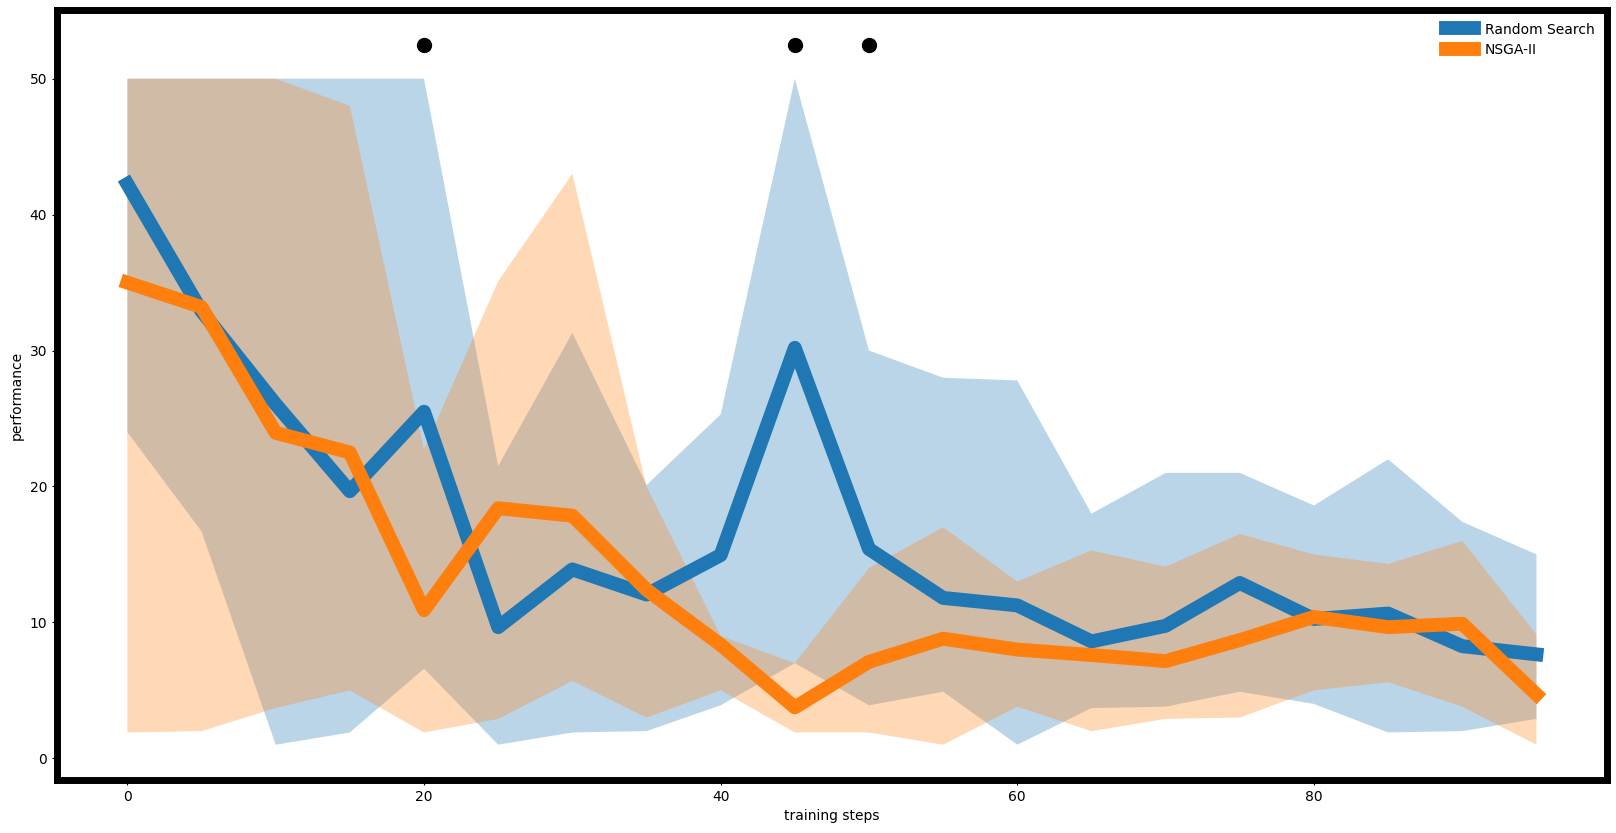

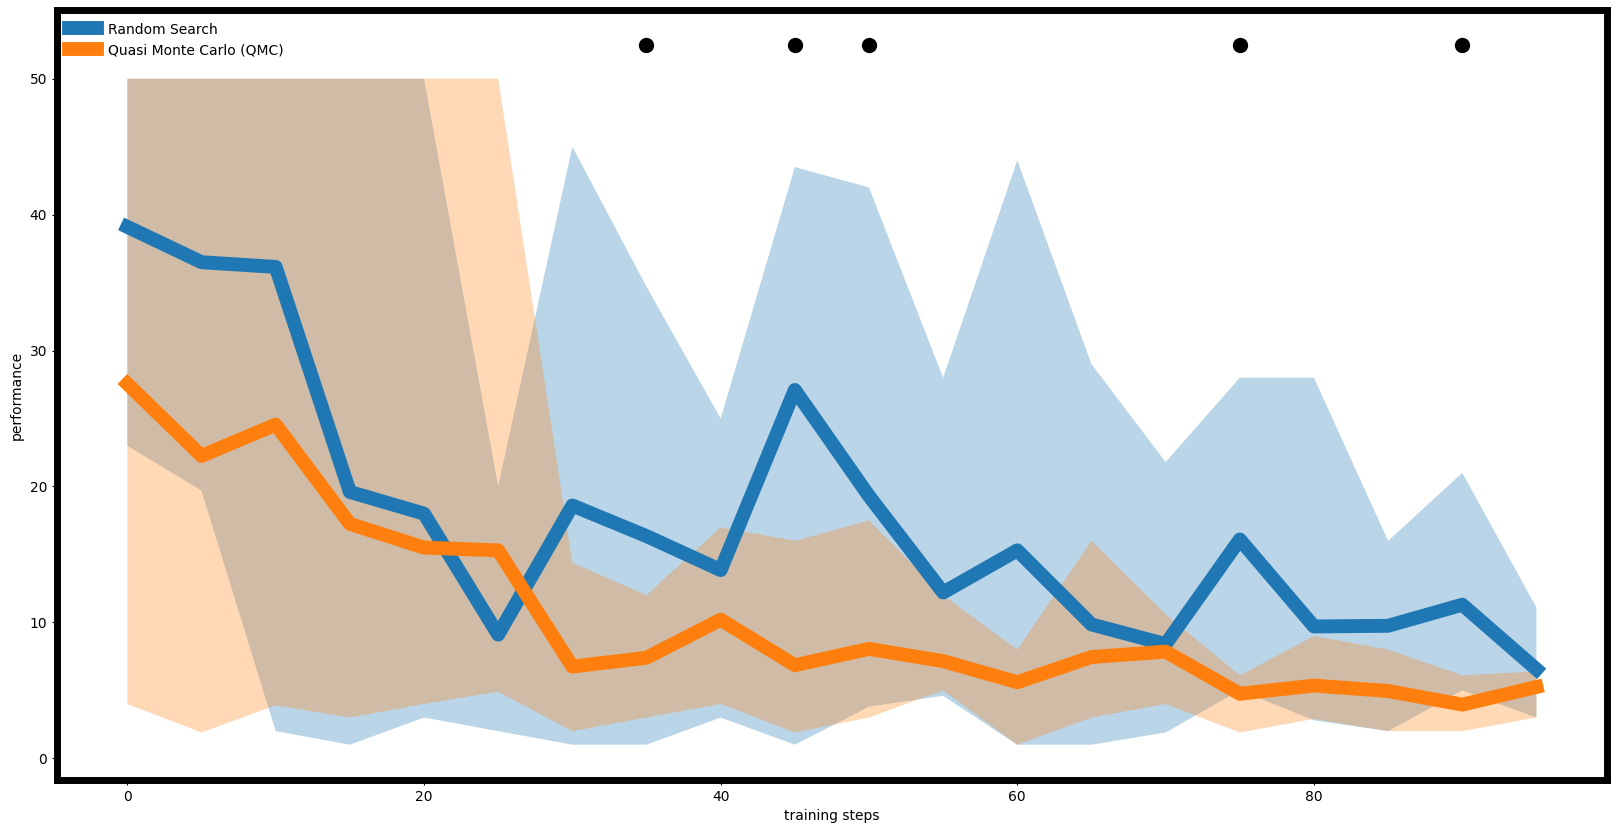

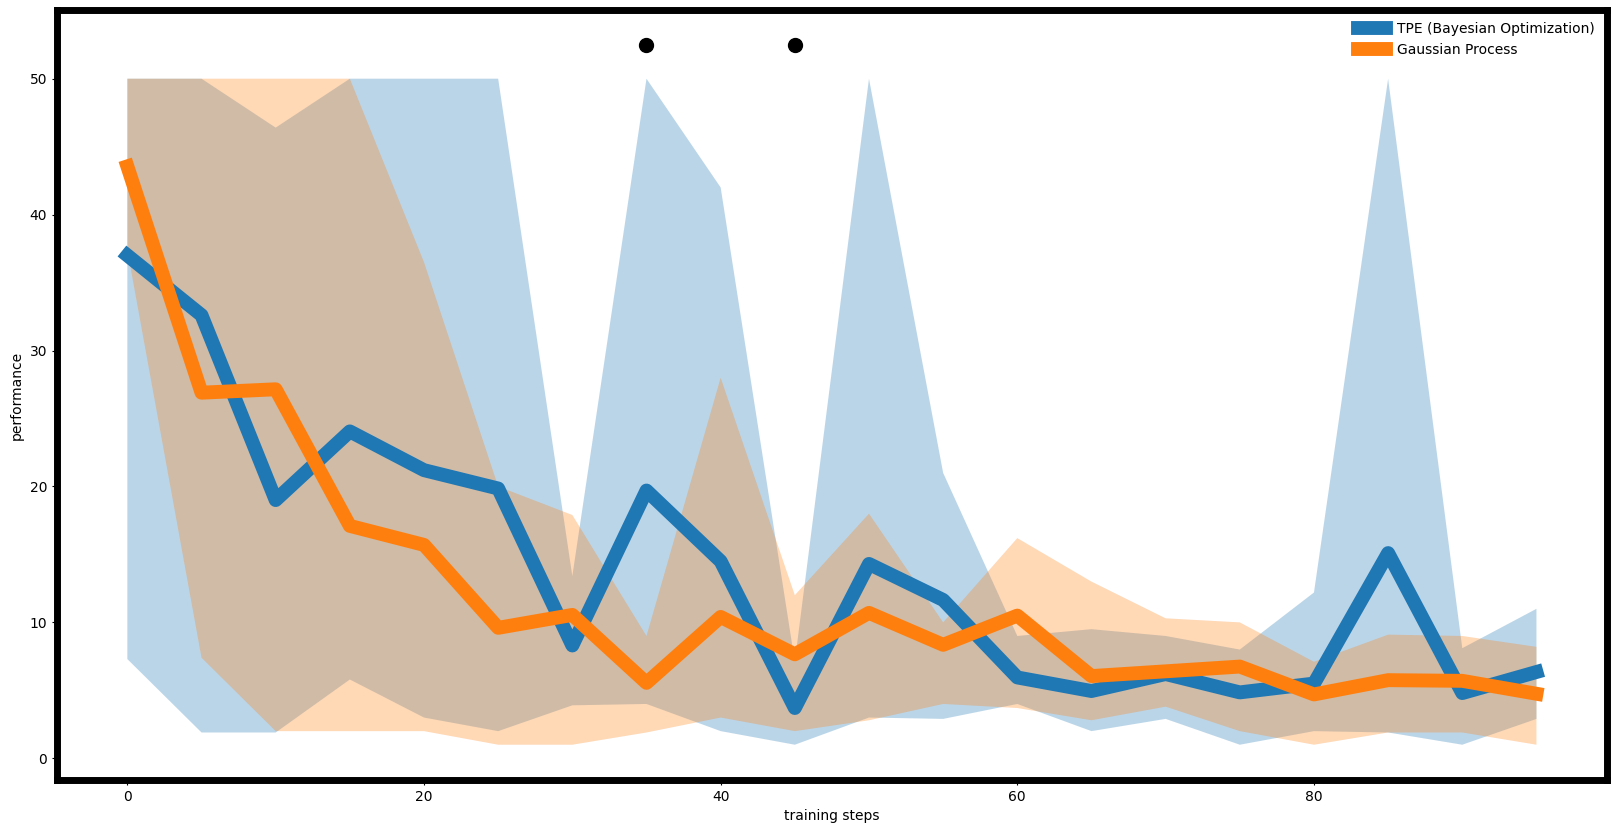

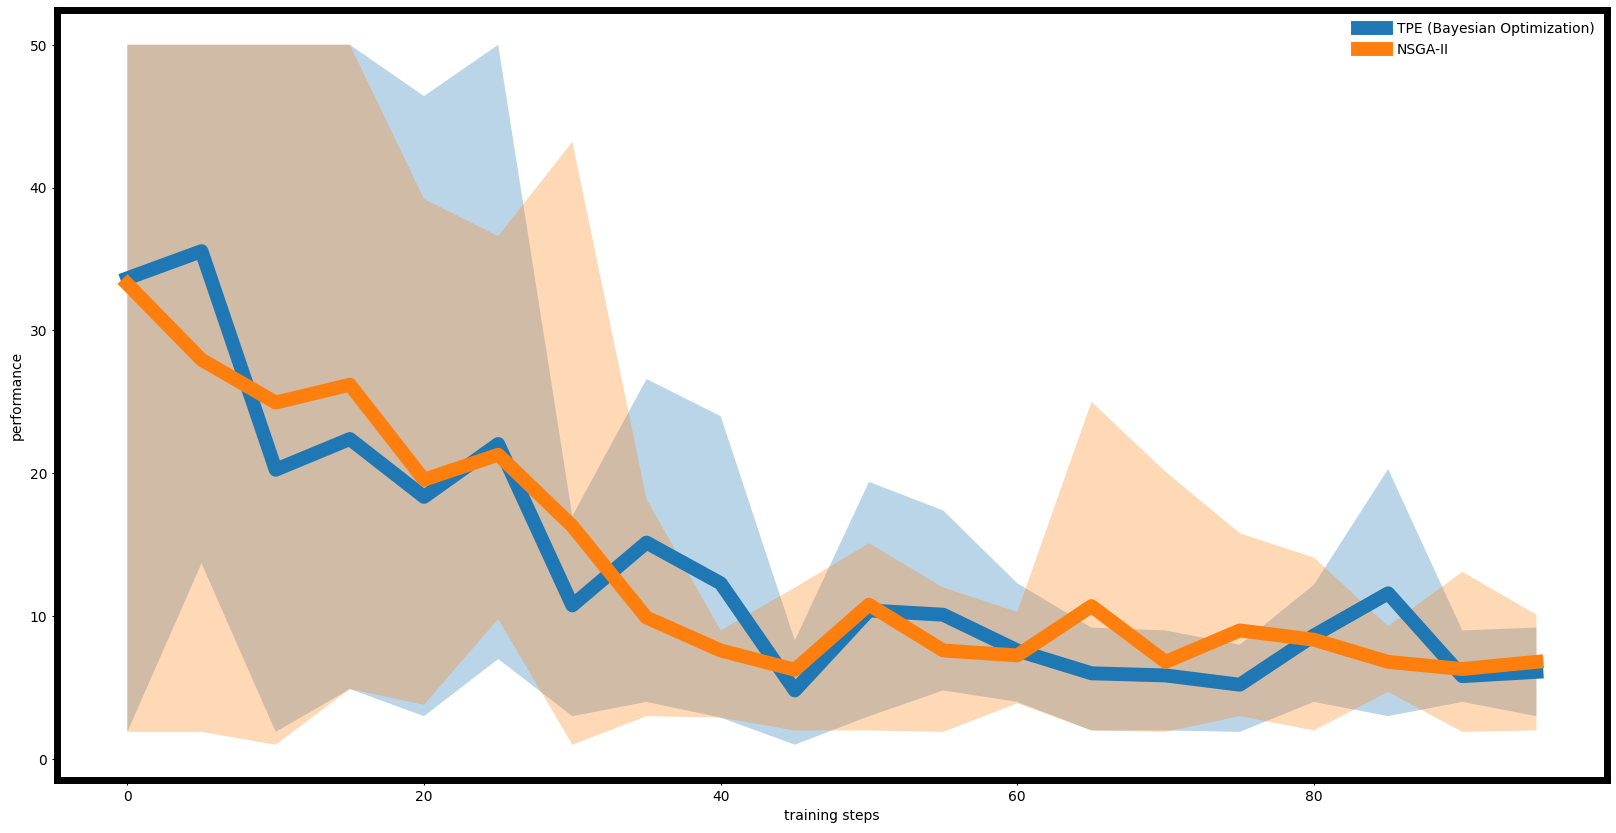

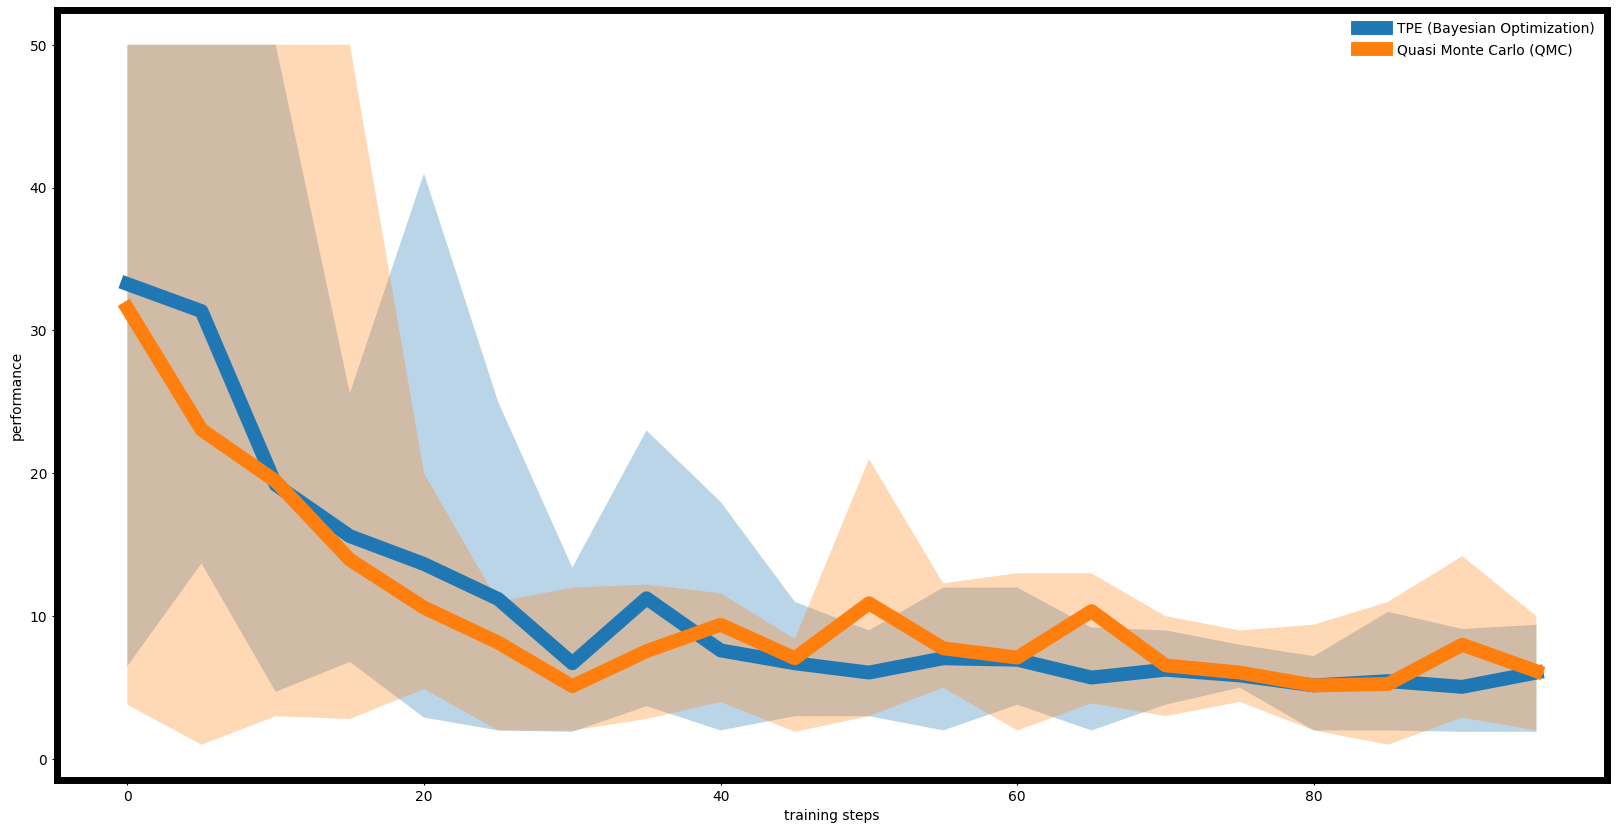

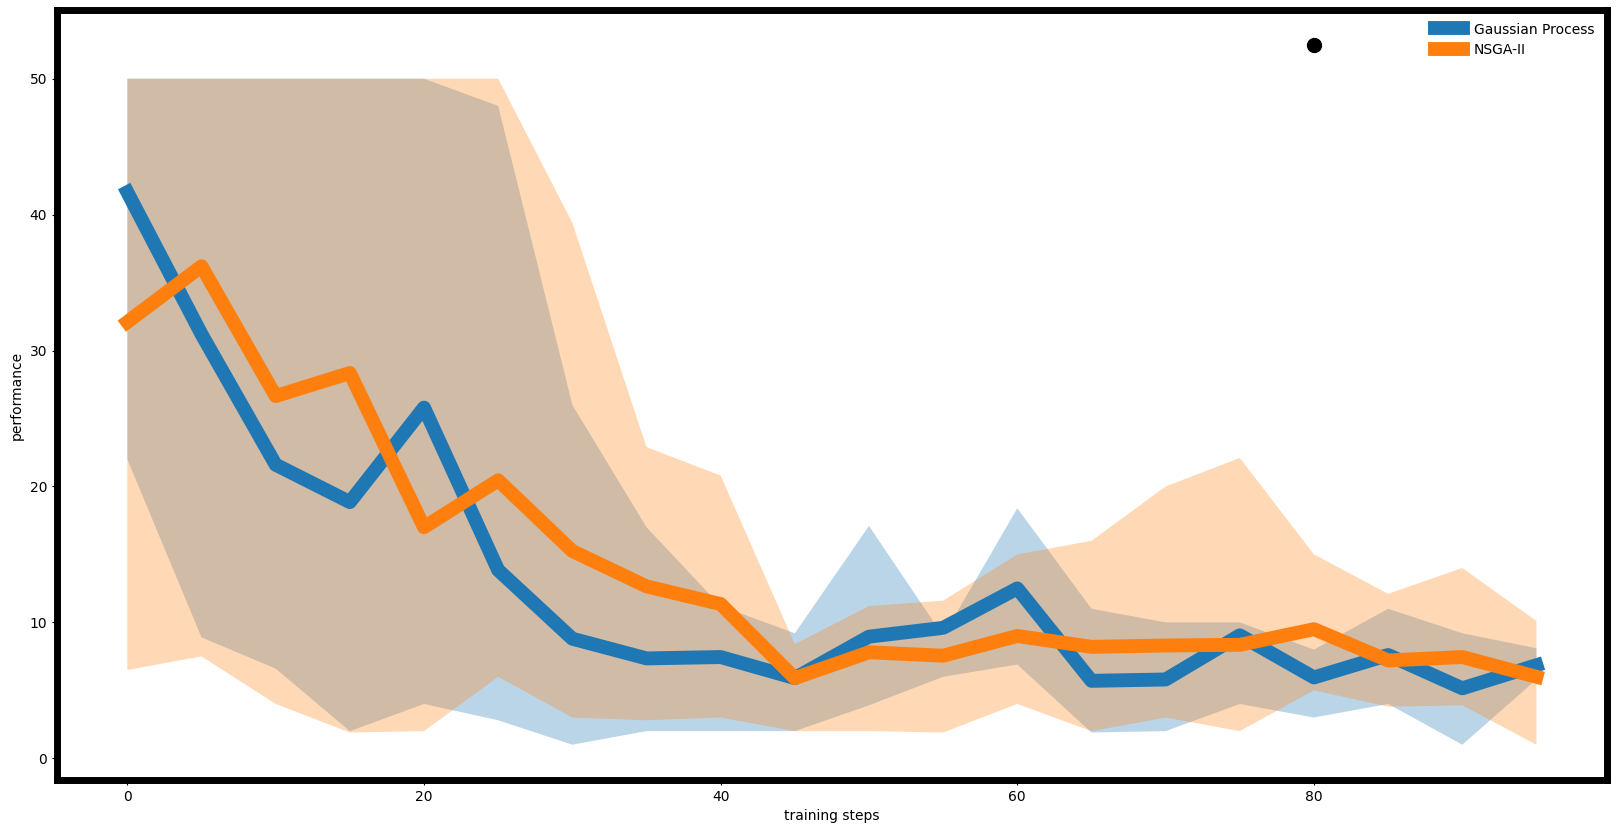

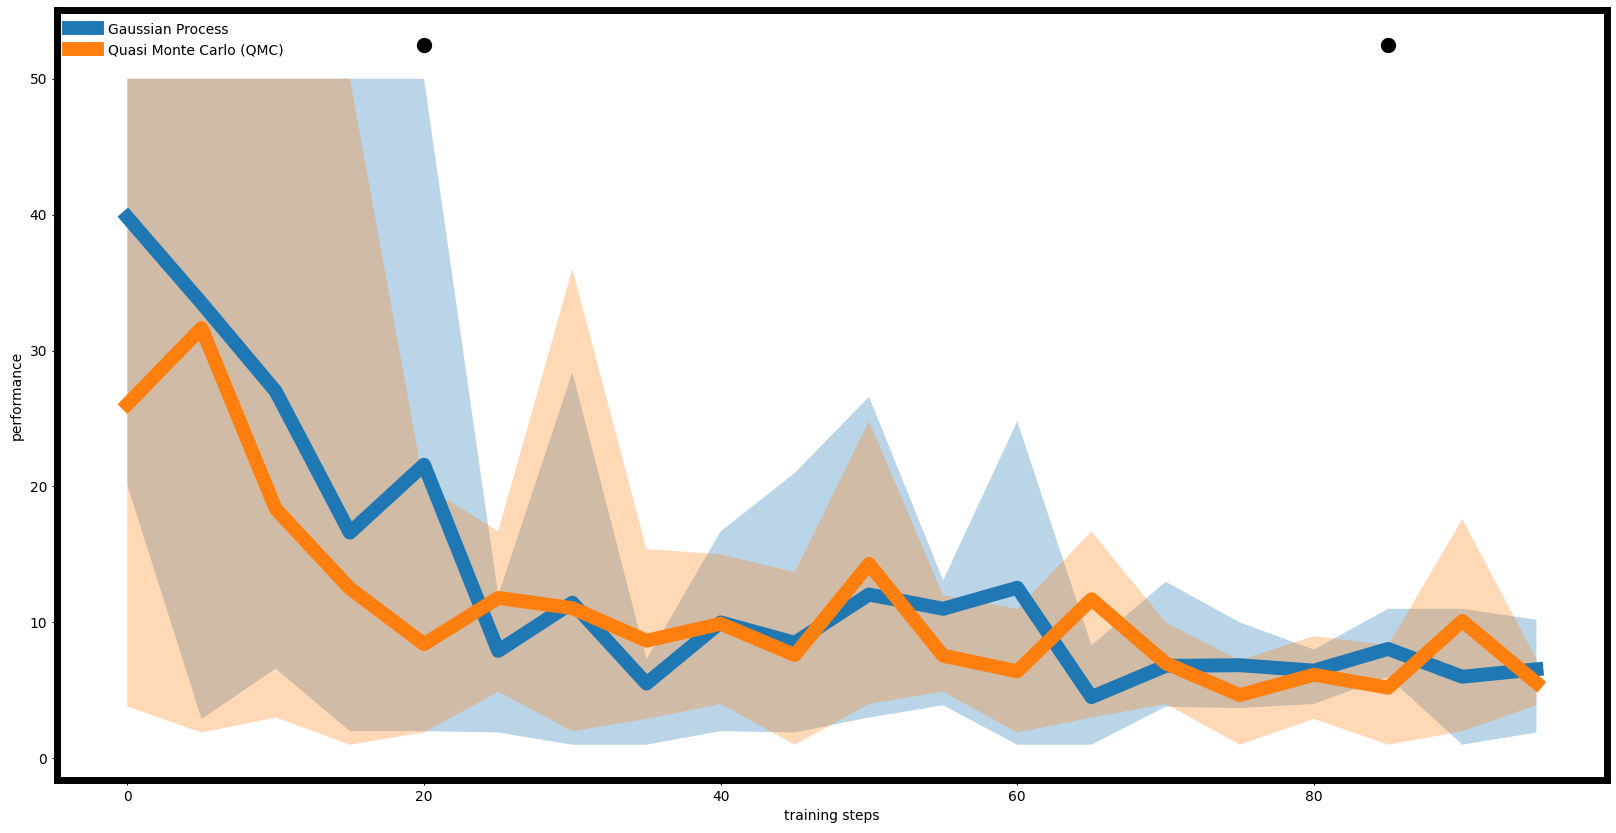

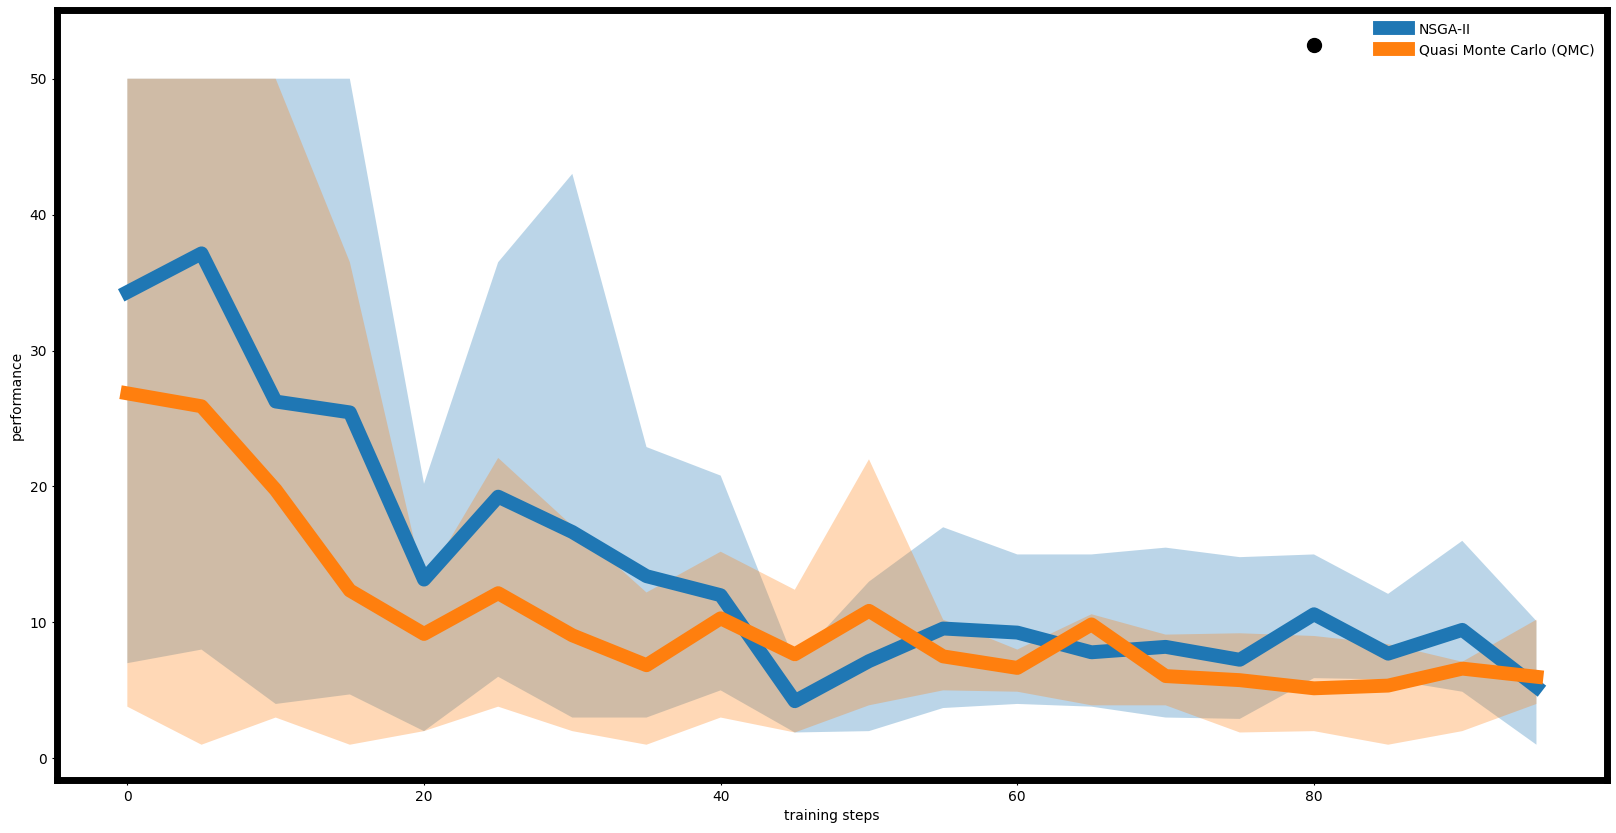

In [20]:
# Nombre de répétitions (ré-exécutions)
n_runs = 20

# Dictionnaire pour stocker les courbes d'apprentissage
learning_curves_per_sampler_repeat = {}

# Relancer l'entraînement n fois avec les meilleurs hyperparamètres pour chaque sampler
for sampler_name, best_params in best_params_per_sampler.items():
    print(f"\nRelancement de {sampler_name} avec les meilleurs hyperparamètres...")

    # Initialiser une liste pour stocker les courbes d'apprentissage pour chaque répétition
    repeated_learning_curves = []

    # Extraire les meilleurs hyperparamètres pour ce sampler
    best_alpha_actor = best_params['alpha_actor']
    best_alpha_critic = best_params['alpha_critic']

    # Exécuter l'entraînement n fois avec les meilleurs hyperparamètres
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs} pour {sampler_name}")
        # Créer un nouvel environnement et exécuter l'algorithme acteur-critique
        #env = create_maze_from_params(ac_params)
        _, V, learning_curve = naive_actor_critic(env, best_alpha_actor, best_alpha_critic, ac_params['gamma'], ac_params['nb_episodes'], ac_params['timeout'], render=False)
        repeated_learning_curves.append(learning_curve)

    # Stocker les courbes d'apprentissage répétées dans le dictionnaire
    learning_curves_per_sampler_repeat[sampler_name] = np.array(repeated_learning_curves)

# Comparer les performances des samplers avec les tests statistiques
sampler_names = list(learning_curves_per_sampler_repeat.keys())

# Comparer chaque paire de samplers
for i in range(len(sampler_names)):
    for j in range(i + 1, len(sampler_names)):
        sampler1 = sampler_names[i]
        sampler2 = sampler_names[j]

        print(f"\nComparaison de {sampler1} vs {sampler2}")

        # Extraire les performances répétées (courbes d'apprentissage) pour chaque sampler
        perf1 = learning_curves_per_sampler_repeat[sampler1]  # (n_runs, num_episodes)
        perf2 = learning_curves_per_sampler_repeat[sampler2]  # (n_runs, num_episodes)

        # Effectuer le test statistique (Welch's t-test)
        perform_test(perf1, perf2, sampler1, sampler2, sample_size=n_runs, downsampling_fact=5, confidence_level=0.01)


## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

In [21]:
# Number of episodes and repetitions
n_episodes = 150
n_runs = 20  # You can adjust the number of runs for better statistical power

# Naive hyper-parameters (0.5, 0.5)
naive_params = {'alpha_actor': 0.5, 'alpha_critic': 0.5}

# Relancer l'entraînement avec naïve tuning et les meilleurs hyper-paramètres
learning_curves = {}  # Dictionnaire pour stocker les courbes d'apprentissage

# Collect naive tuning learning curves
print("\nCollecting naive tuning (0.5, 0.5) learning curves...")
naive_learning_curves = []
for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs} for naive tuning...")
    #env = create_maze_from_params(ac_params)
    _, _, learning_curve = naive_actor_critic(env, naive_params['alpha_actor'], naive_params['alpha_critic'], ac_params['gamma'], n_episodes, ac_params['timeout'], render=False)
    naive_learning_curves.append(learning_curve)
learning_curves["naive"] = np.array(naive_learning_curves)

# Collect learning curves for each best hyper-parameters found from tuning
for sampler_name, best_params in best_params_per_sampler.items():
    print(f"\nCollecting learning curves for {sampler_name}...")
    repeated_learning_curves = []
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs} for {sampler_name}")
        env = create_maze_from_params(ac_params)
        _, _, learning_curve = naive_actor_critic(env, best_params['alpha_actor'], best_params['alpha_critic'], ac_params['gamma'], n_episodes, ac_params['timeout'], render=False)
        repeated_learning_curves.append(learning_curve)
    learning_curves[sampler_name] = np.array(repeated_learning_curves)



Run 1/20 for naive tuning...
Run 2/20 for naive tuning...
Run 3/20 for naive tuning...
Run 4/20 for naive tuning...
Run 5/20 for naive tuning...
Run 6/20 for naive tuning...
Run 7/20 for naive tuning...
Run 8/20 for naive tuning...
Run 9/20 for naive tuning...
Run 10/20 for naive tuning...
Run 11/20 for naive tuning...
Run 12/20 for naive tuning...
Run 13/20 for naive tuning...
Run 14/20 for naive tuning...
Run 15/20 for naive tuning...
Run 16/20 for naive tuning...
Run 17/20 for naive tuning...
Run 18/20 for naive tuning...
Run 19/20 for naive tuning...
Run 20/20 for naive tuning...

Run 1/20 for Grid Search
Run 2/20 for Grid Search
Run 3/20 for Grid Search
Run 4/20 for Grid Search
Run 5/20 for Grid Search
Run 6/20 for Grid Search
Run 7/20 for Grid Search
Run 8/20 for Grid Search
Run 9/20 for Grid Search
Run 10/20 for Grid Search
Run 11/20 for Grid Search
Run 12/20 for Grid Search
Run 13/20 for Grid Search
Run 14/20 for Grid Search
Run 15/20 for Grid Search
Run 16/20 for Grid Search



Comparing naive vs Grid Search

Comparing naive vs Random Search

Comparing naive vs TPE (Bayesian Optimization)

Comparing naive vs Gaussian Process

Comparing naive vs NSGA-II

Comparing naive vs Quasi Monte Carlo (QMC)

Comparing Grid Search vs Random Search

Comparing Grid Search vs TPE (Bayesian Optimization)

Comparing Grid Search vs Gaussian Process

Comparing Grid Search vs NSGA-II

Comparing Grid Search vs Quasi Monte Carlo (QMC)

Comparing Random Search vs TPE (Bayesian Optimization)

Comparing Random Search vs Gaussian Process

Comparing Random Search vs NSGA-II

Comparing Random Search vs Quasi Monte Carlo (QMC)

Comparing TPE (Bayesian Optimization) vs Gaussian Process

Comparing TPE (Bayesian Optimization) vs NSGA-II

Comparing TPE (Bayesian Optimization) vs Quasi Monte Carlo (QMC)

Comparing Gaussian Process vs NSGA-II

Comparing Gaussian Process vs Quasi Monte Carlo (QMC)

Comparing NSGA-II vs Quasi Monte Carlo (QMC)


/tmp/ipykernel_3810/2834138276.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1, figsize=(20, 10))


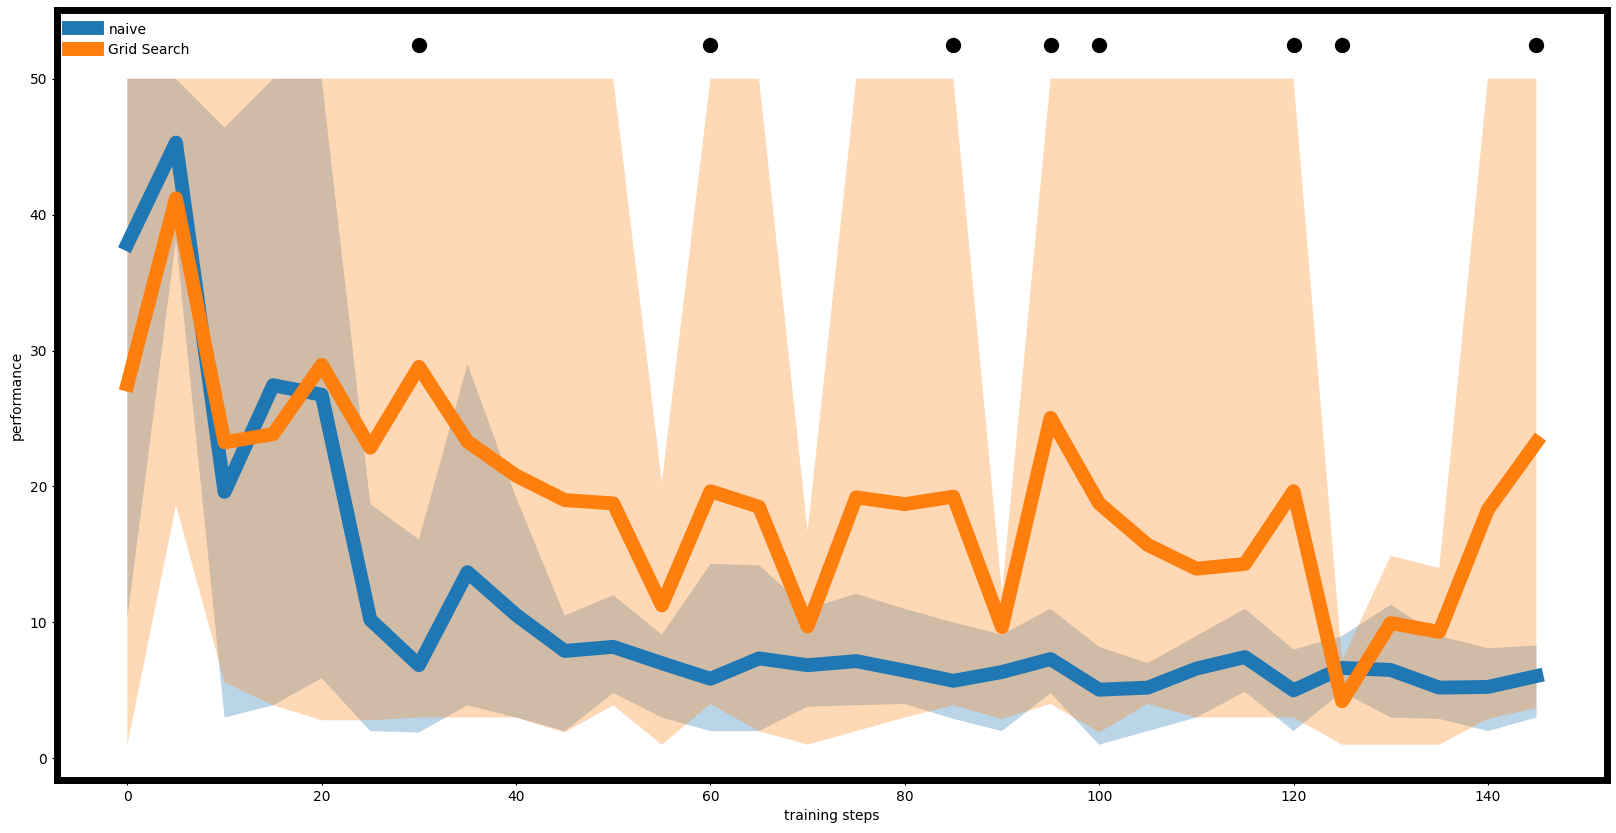

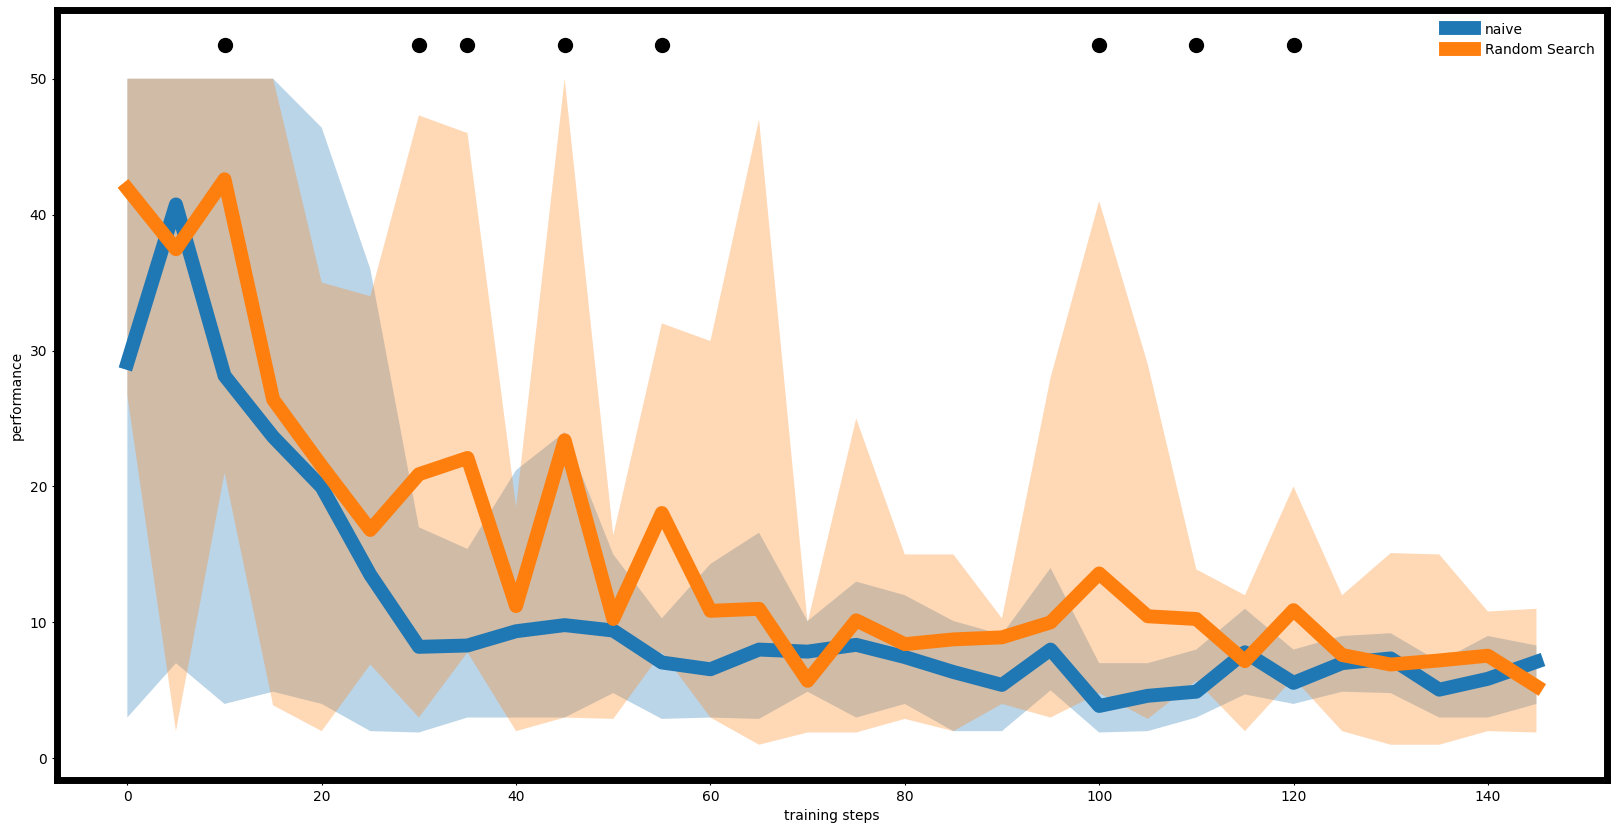

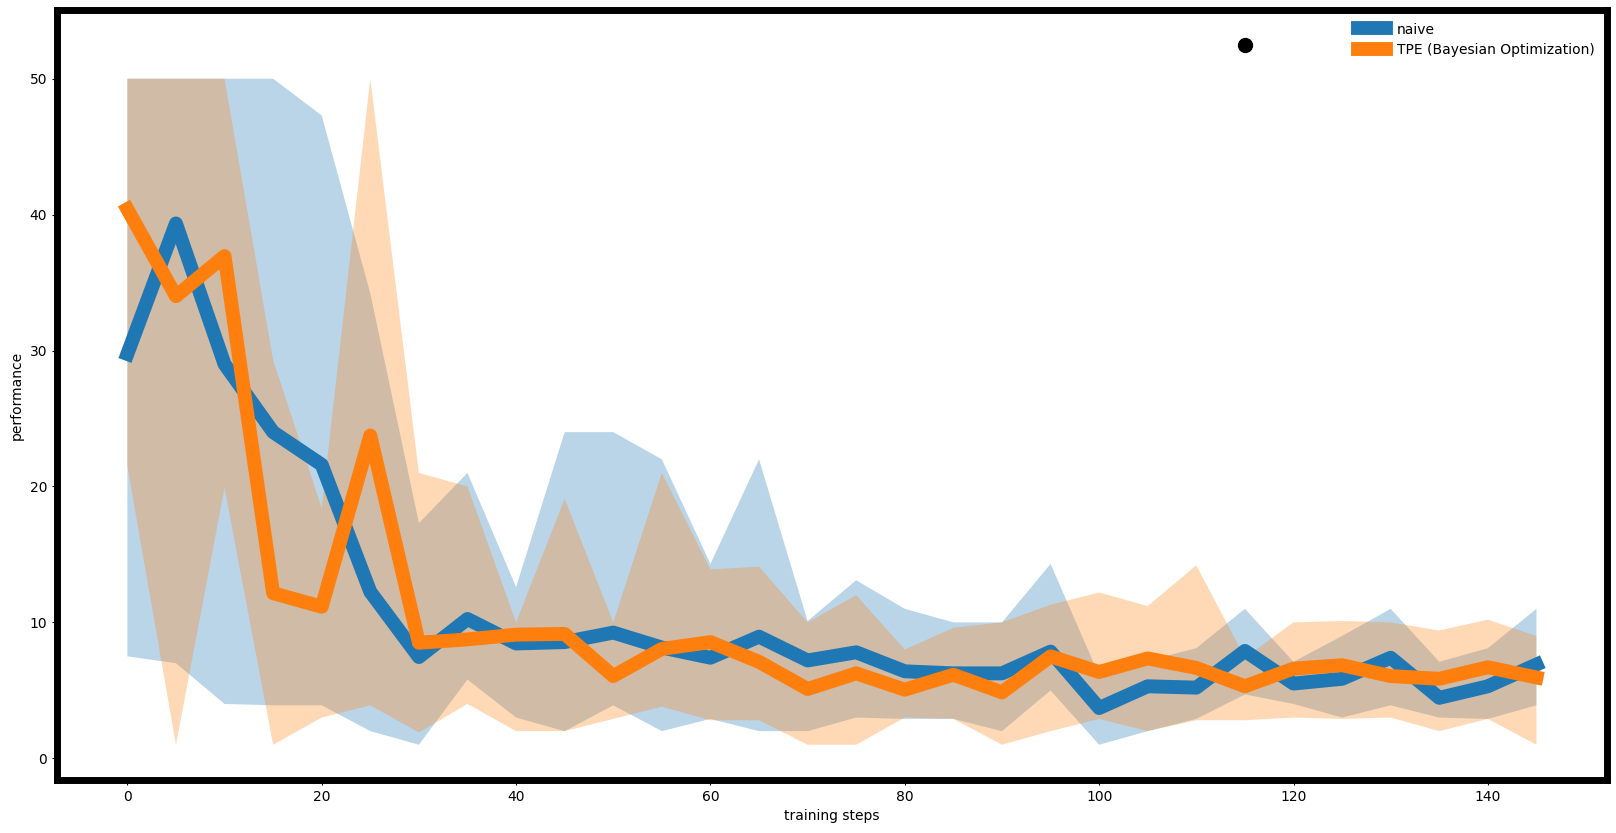

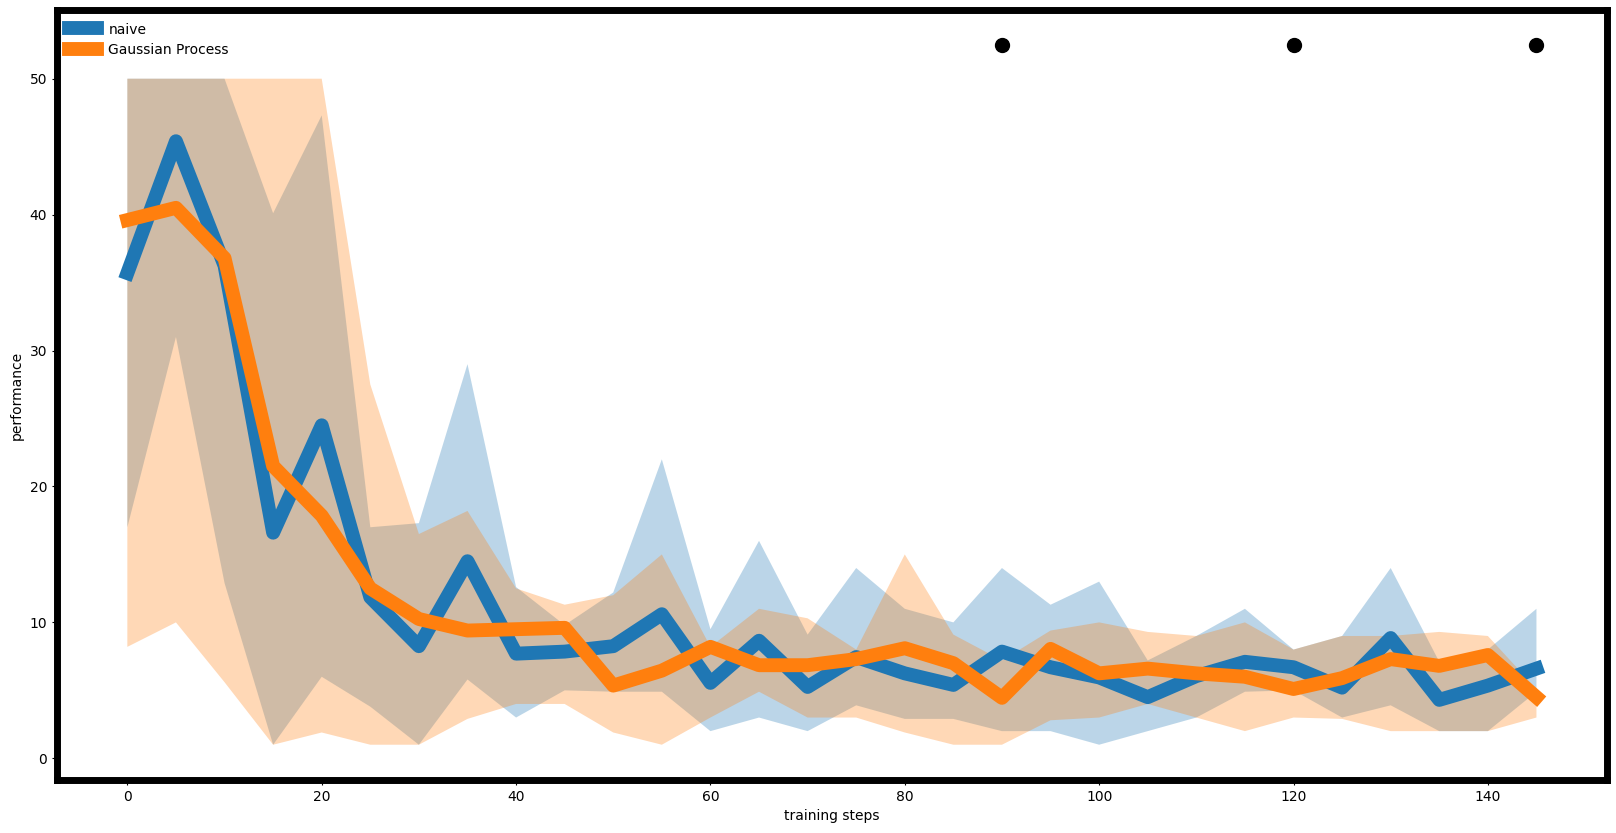

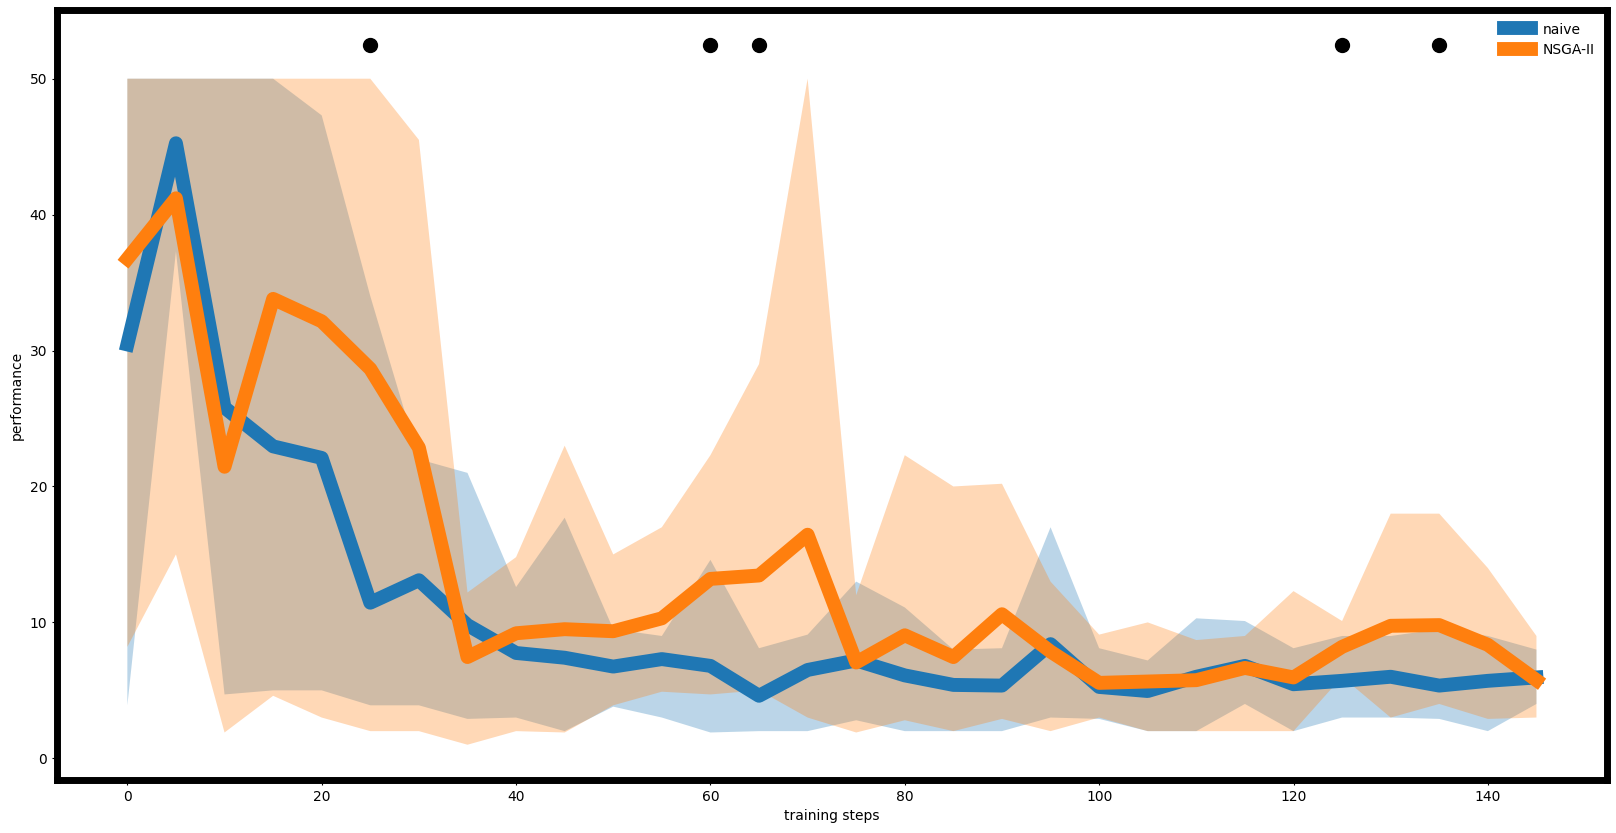

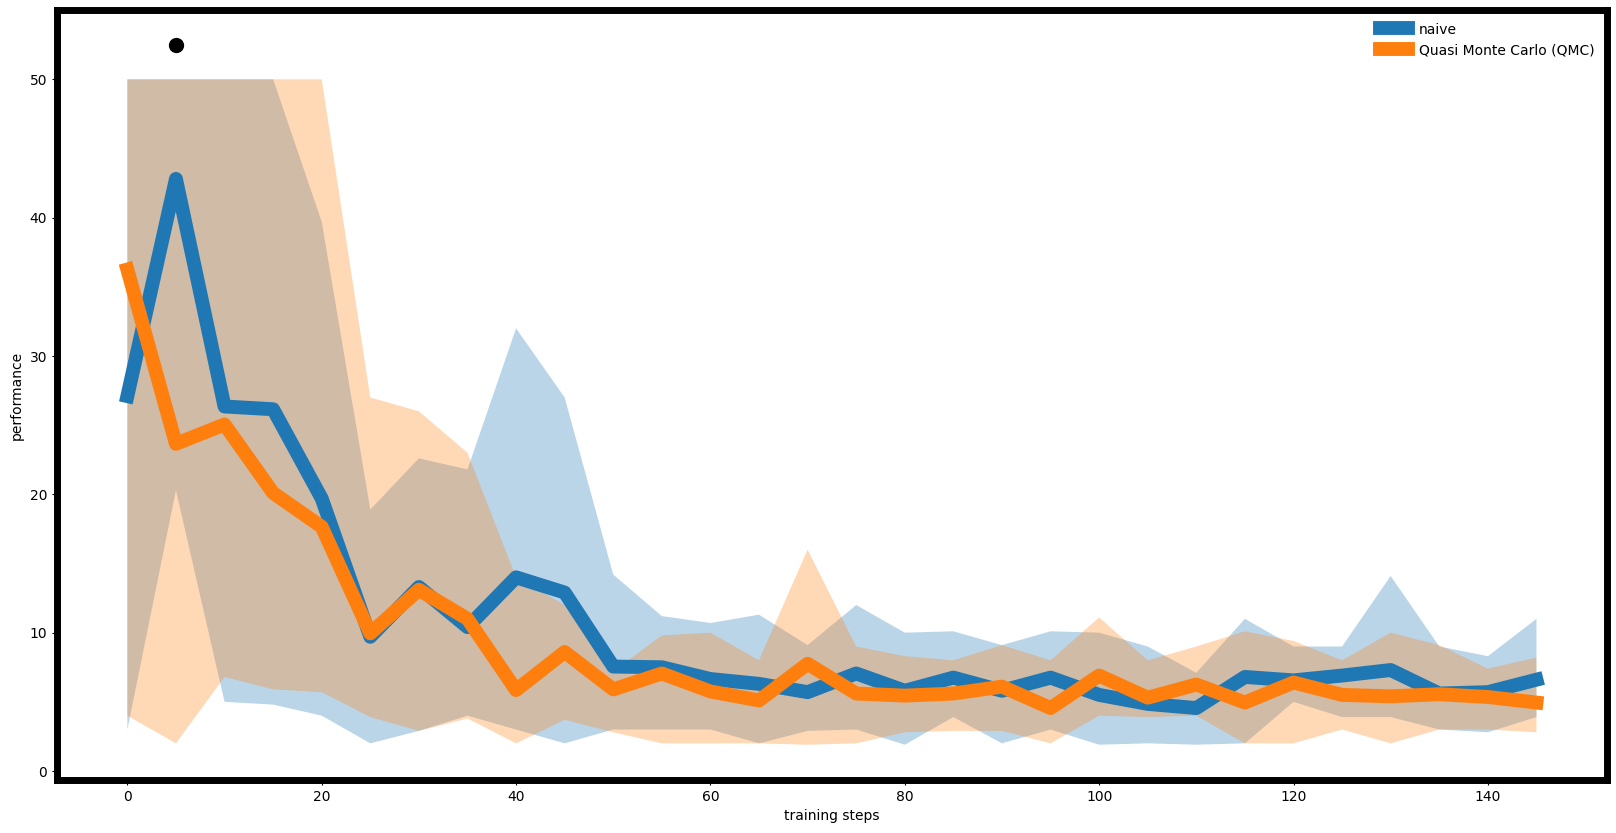

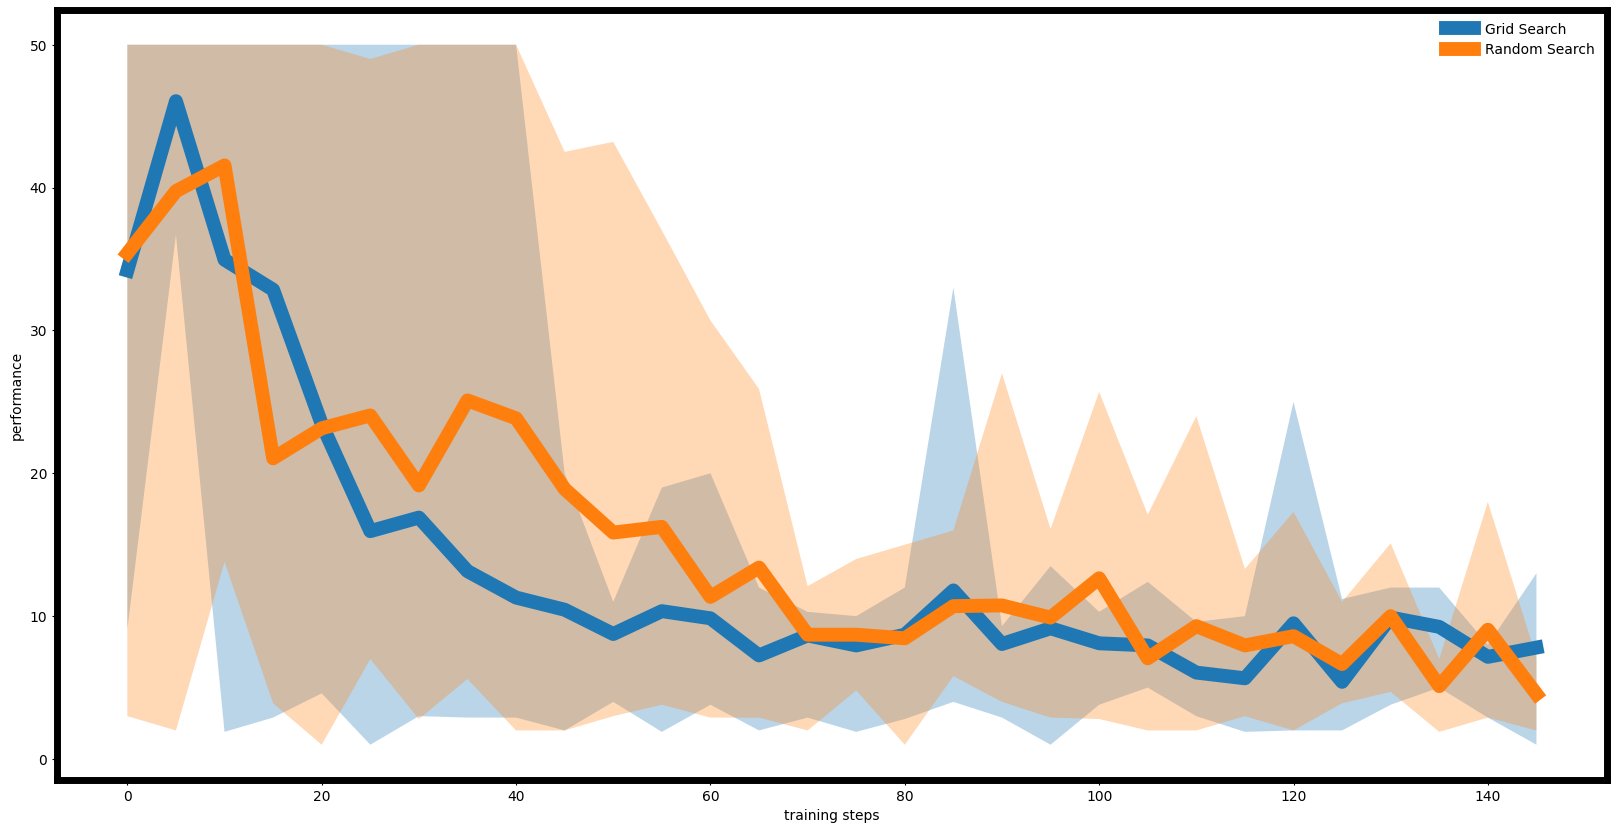

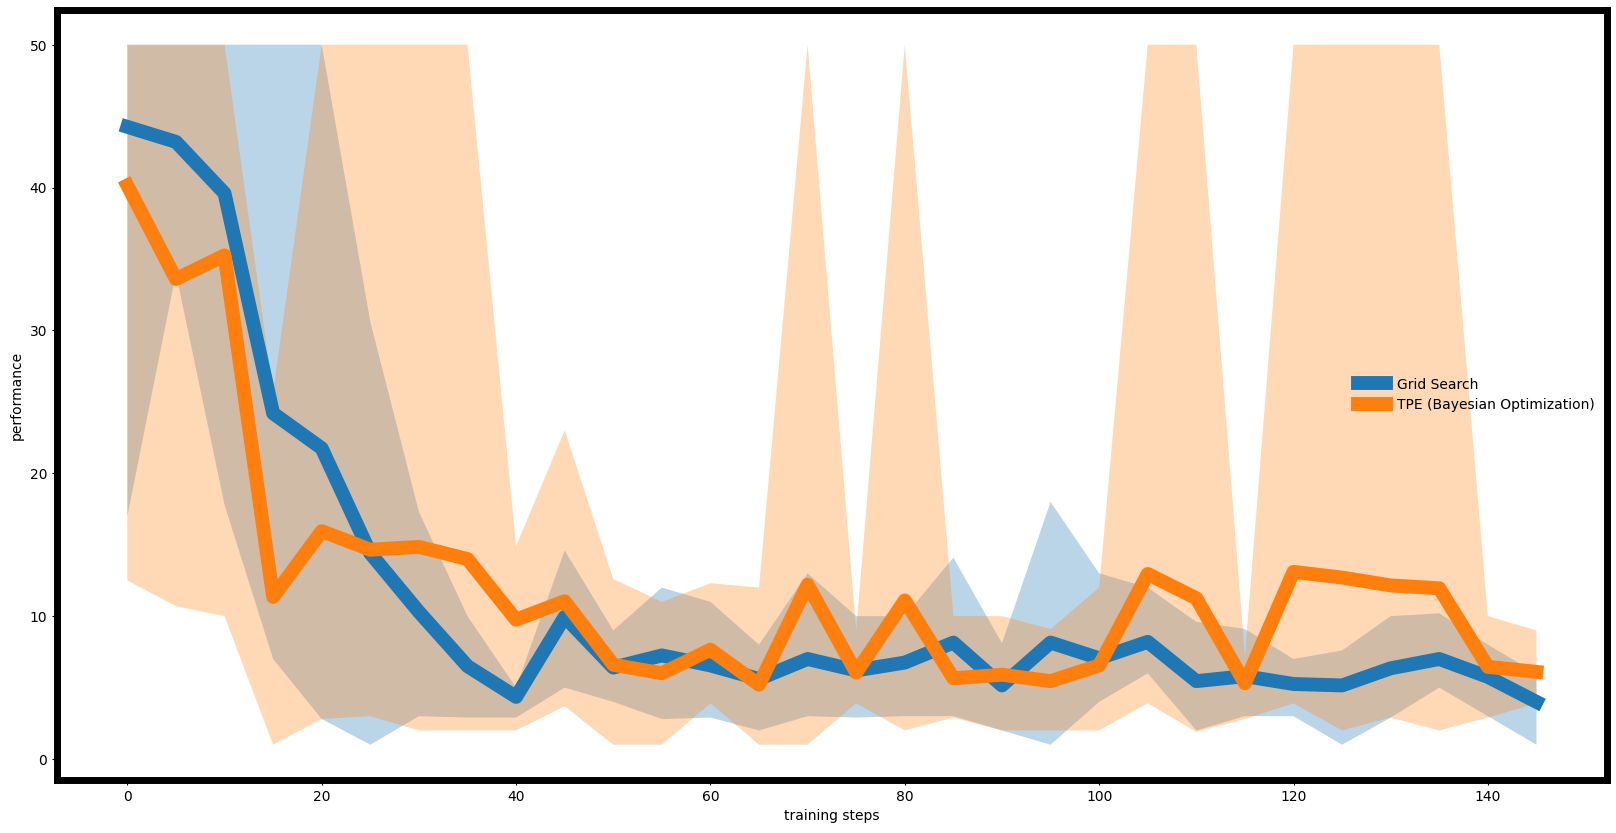

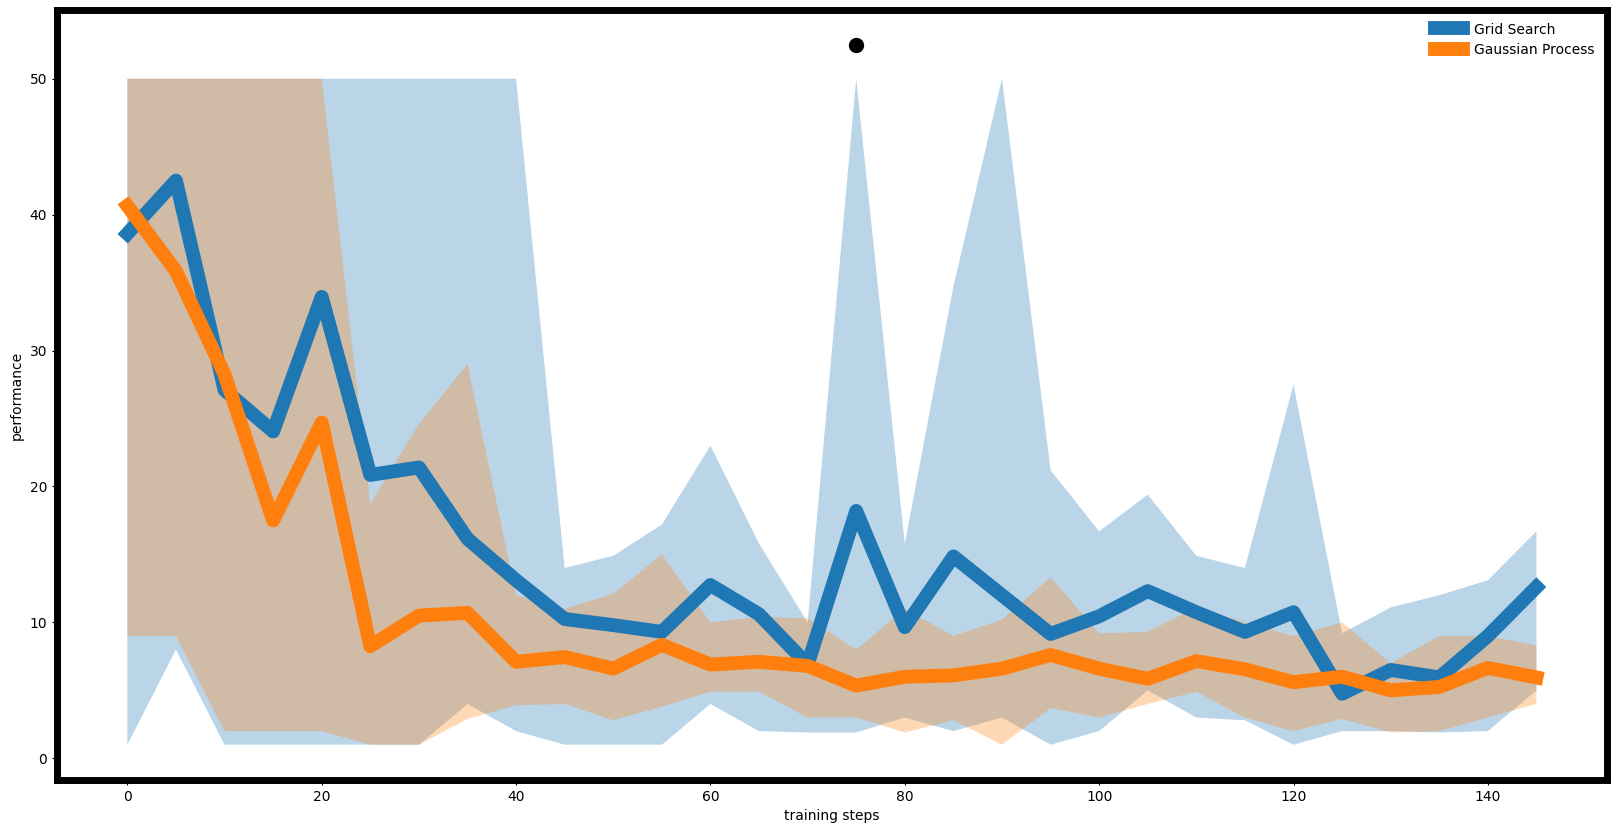

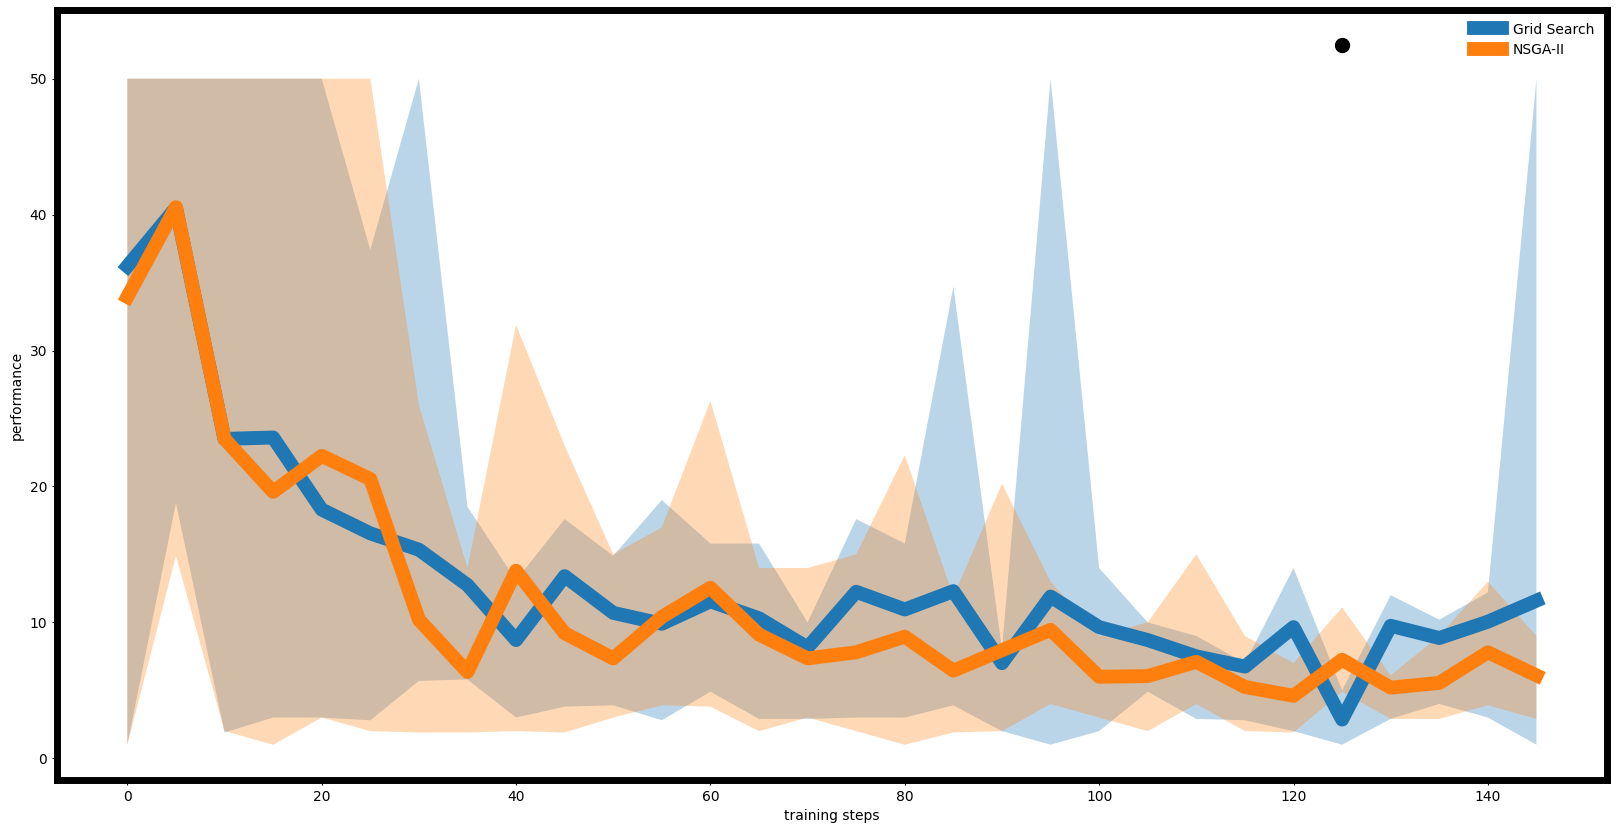

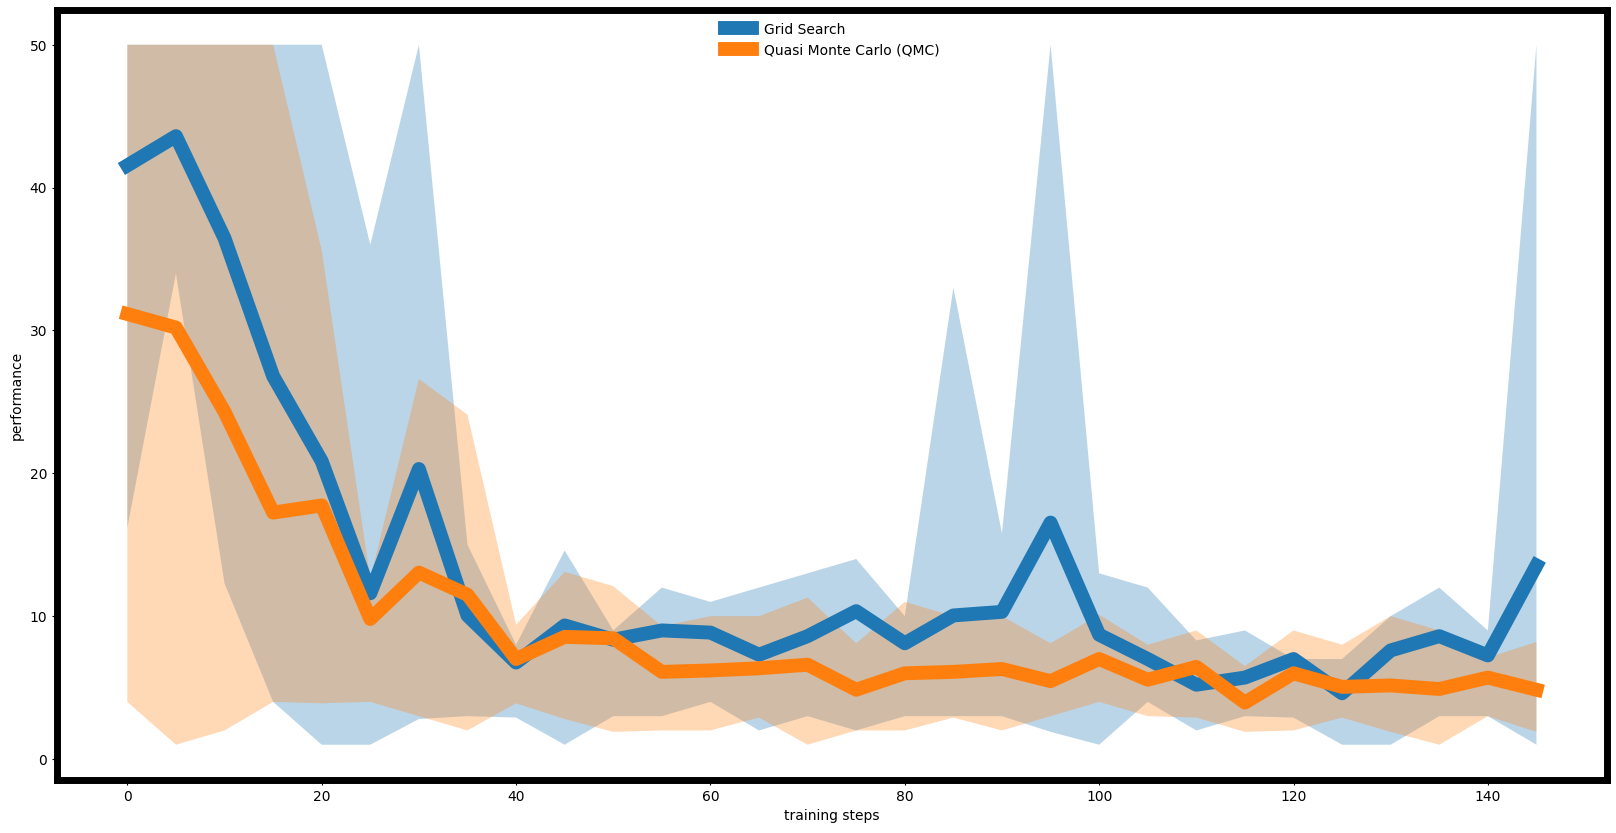

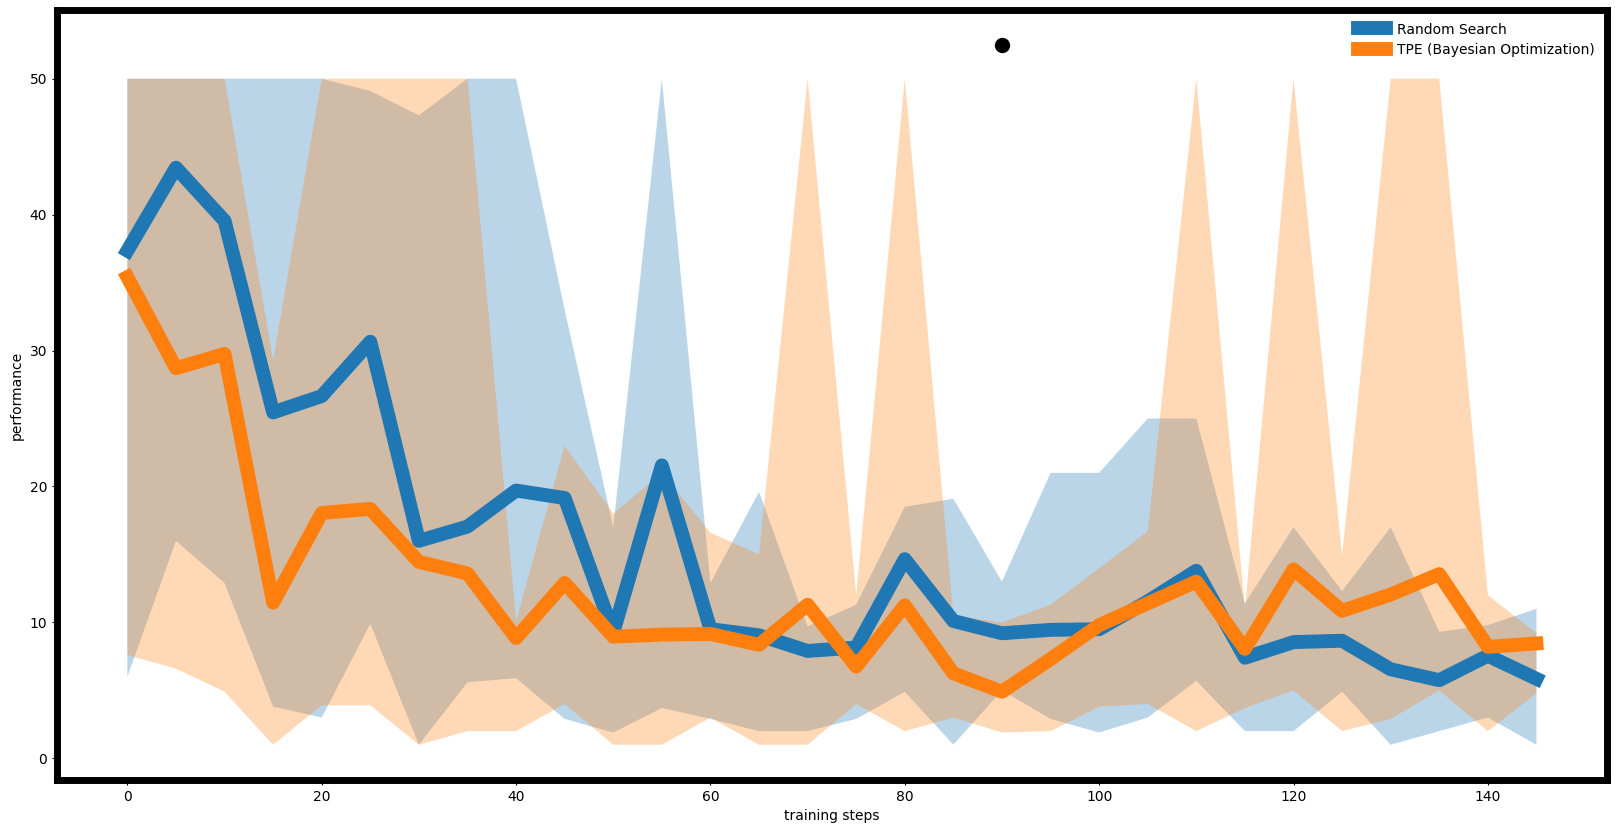

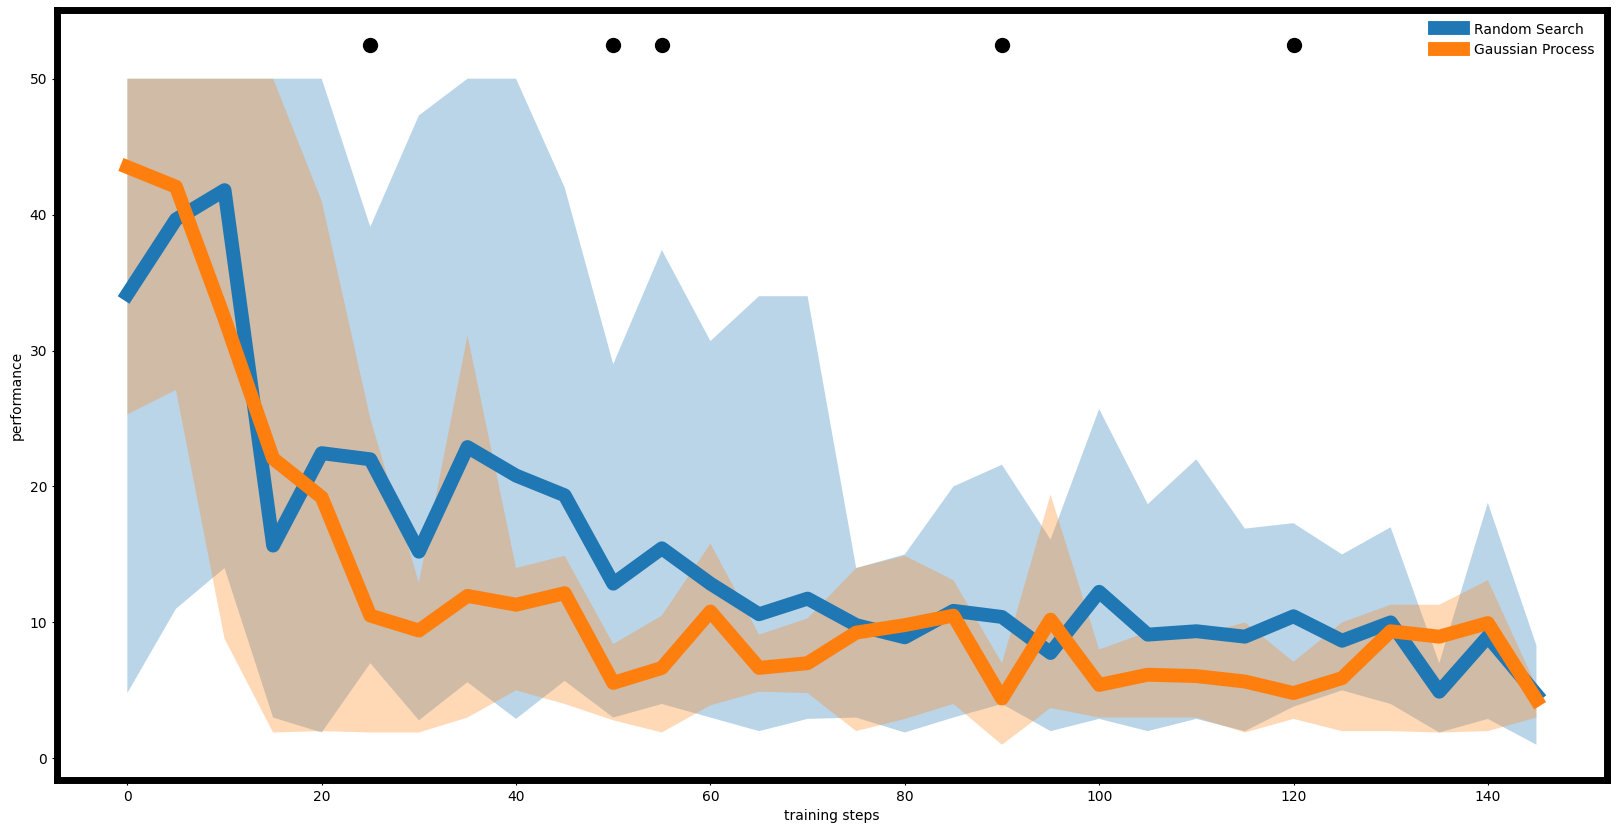

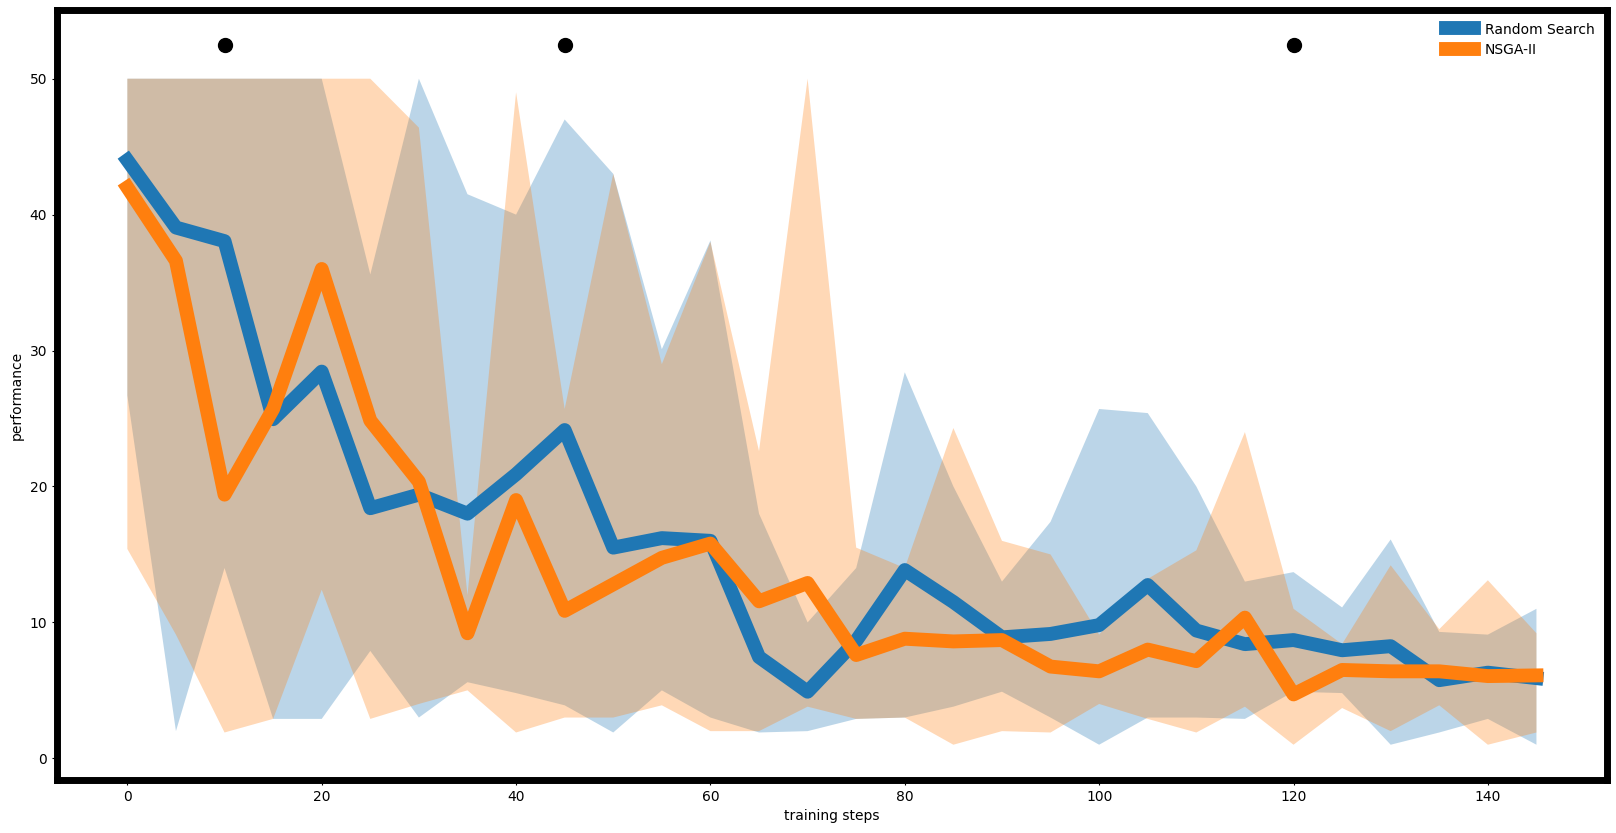

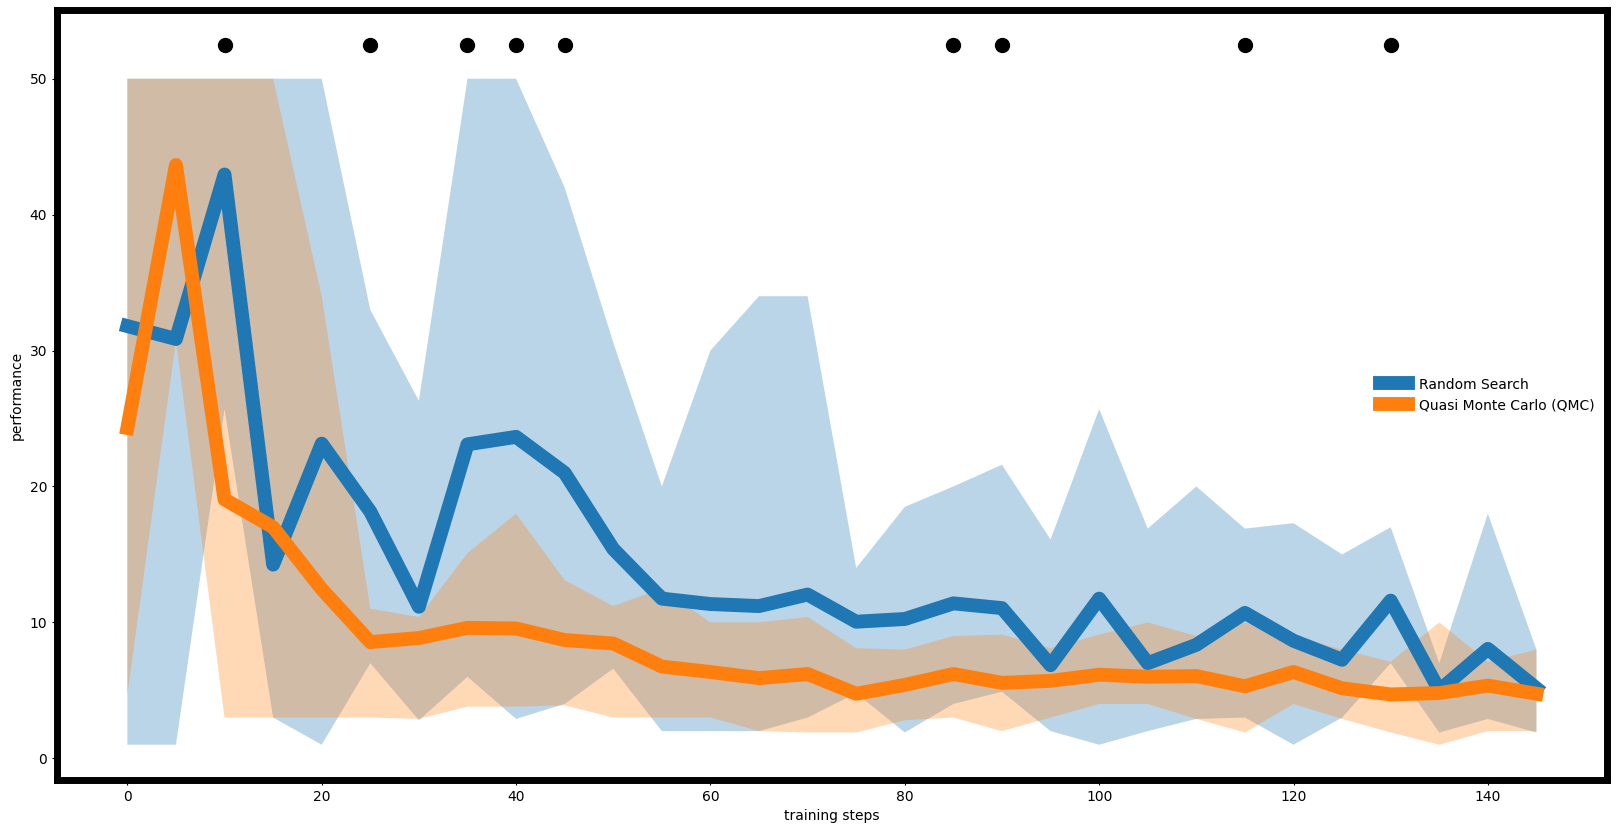

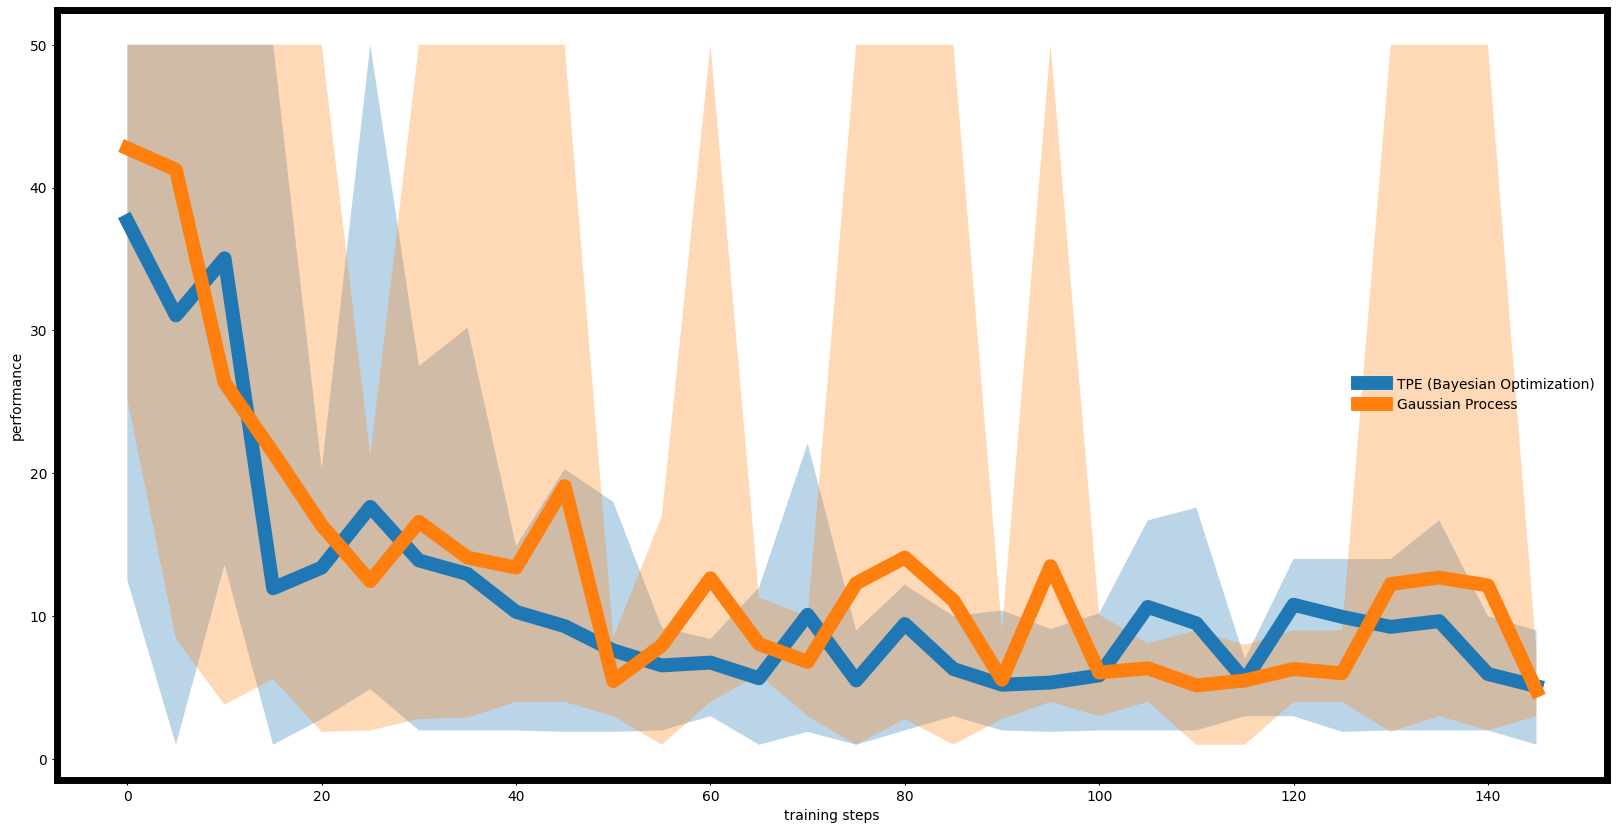

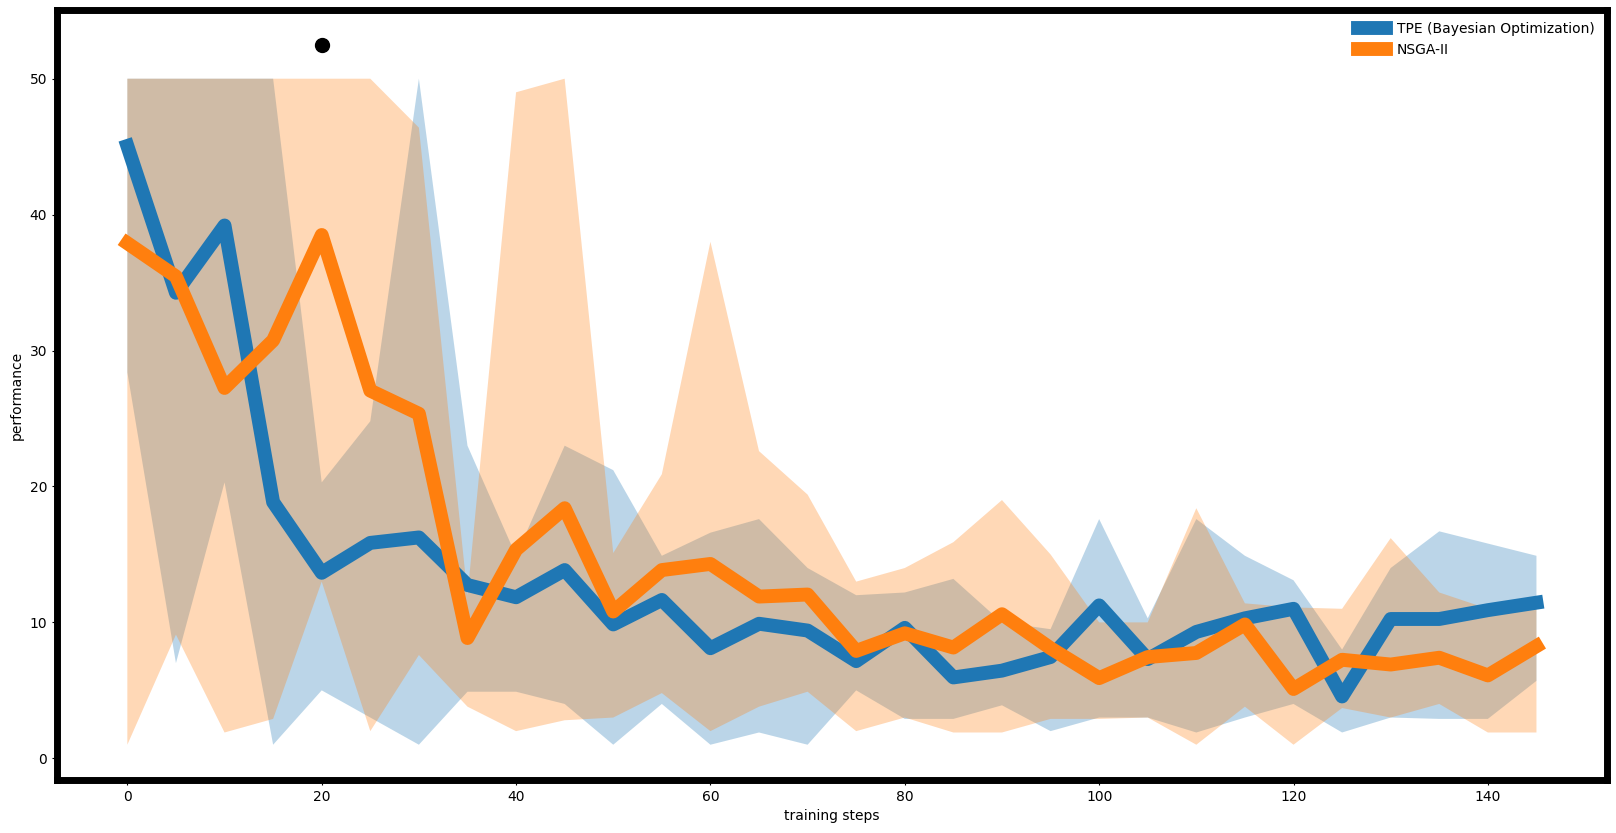

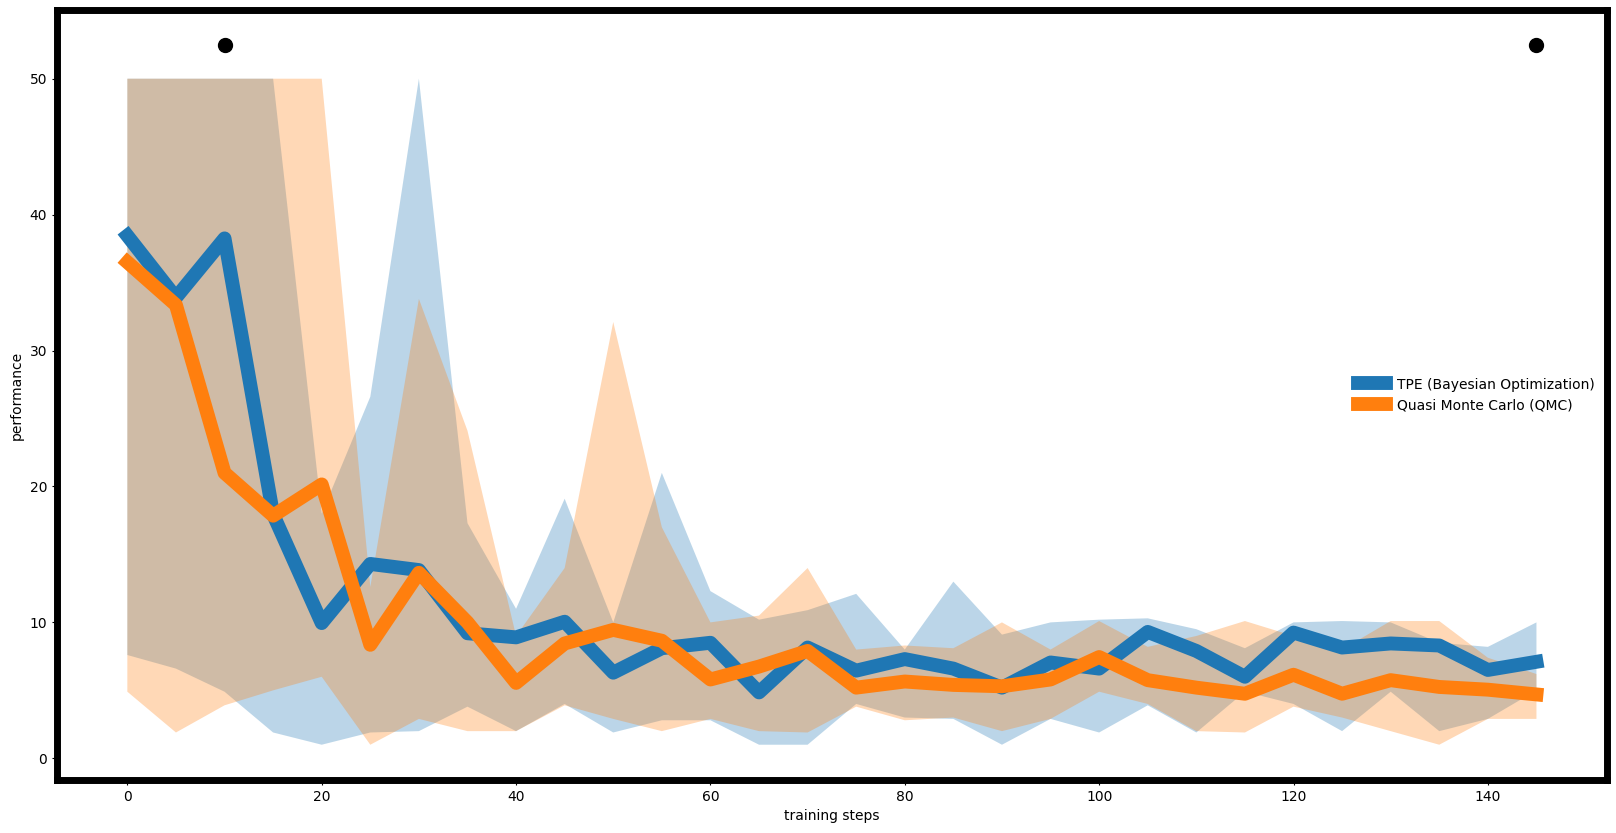

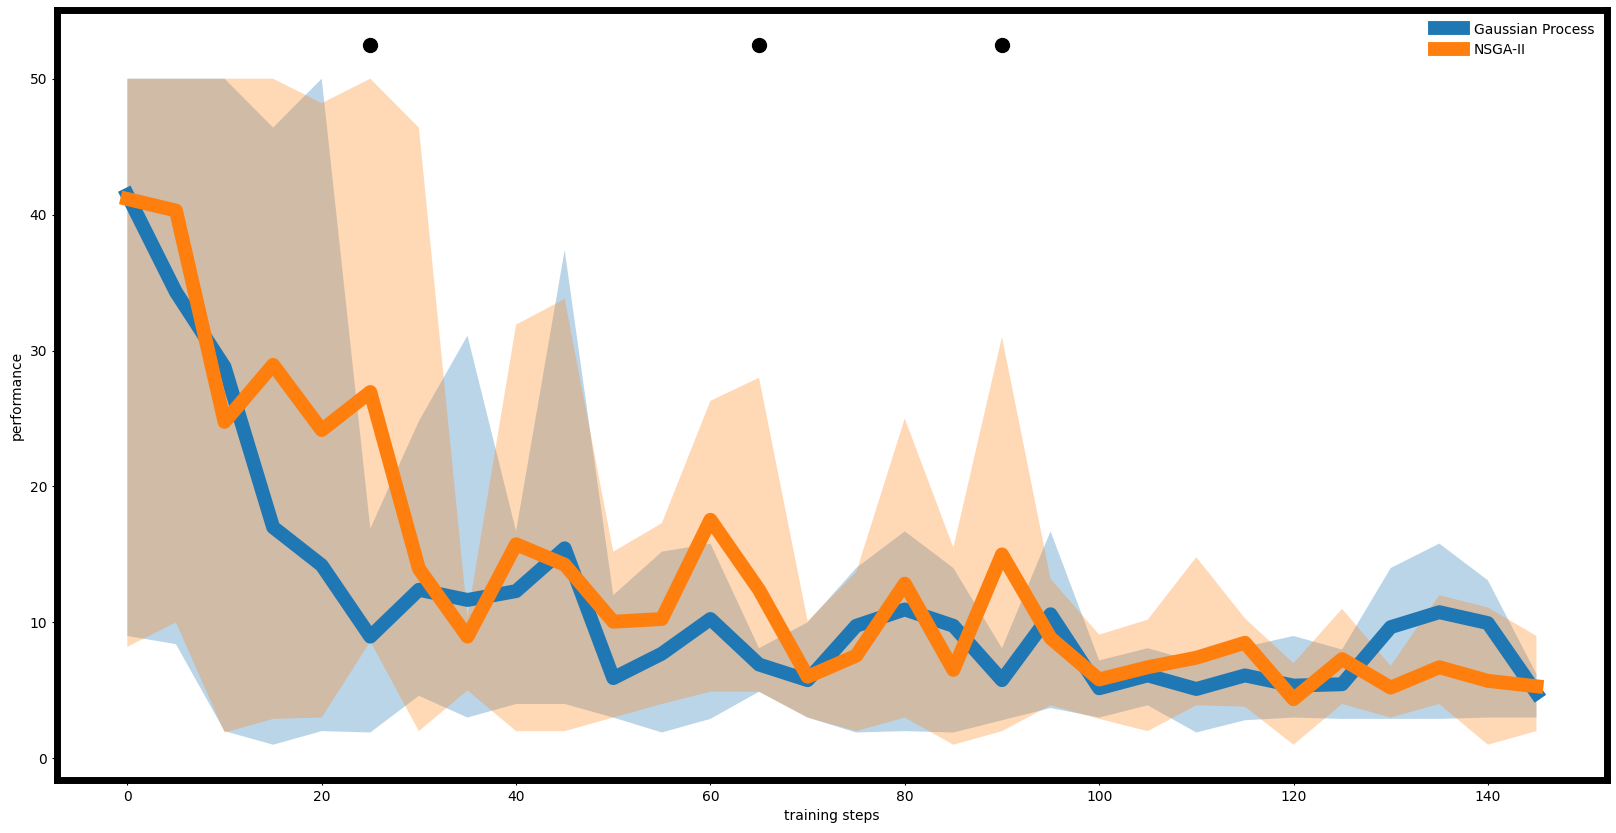

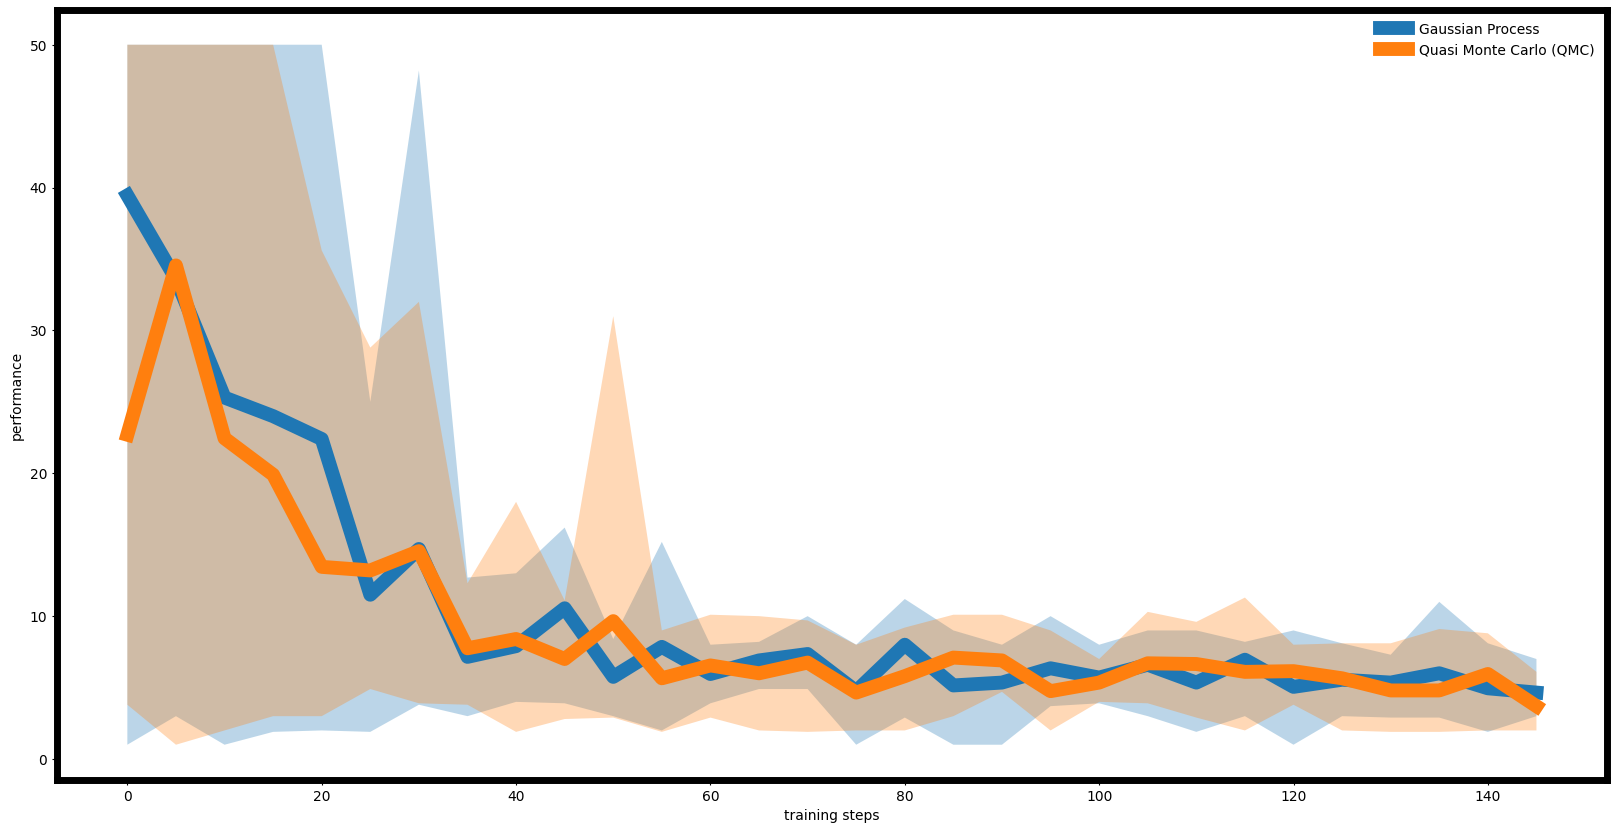

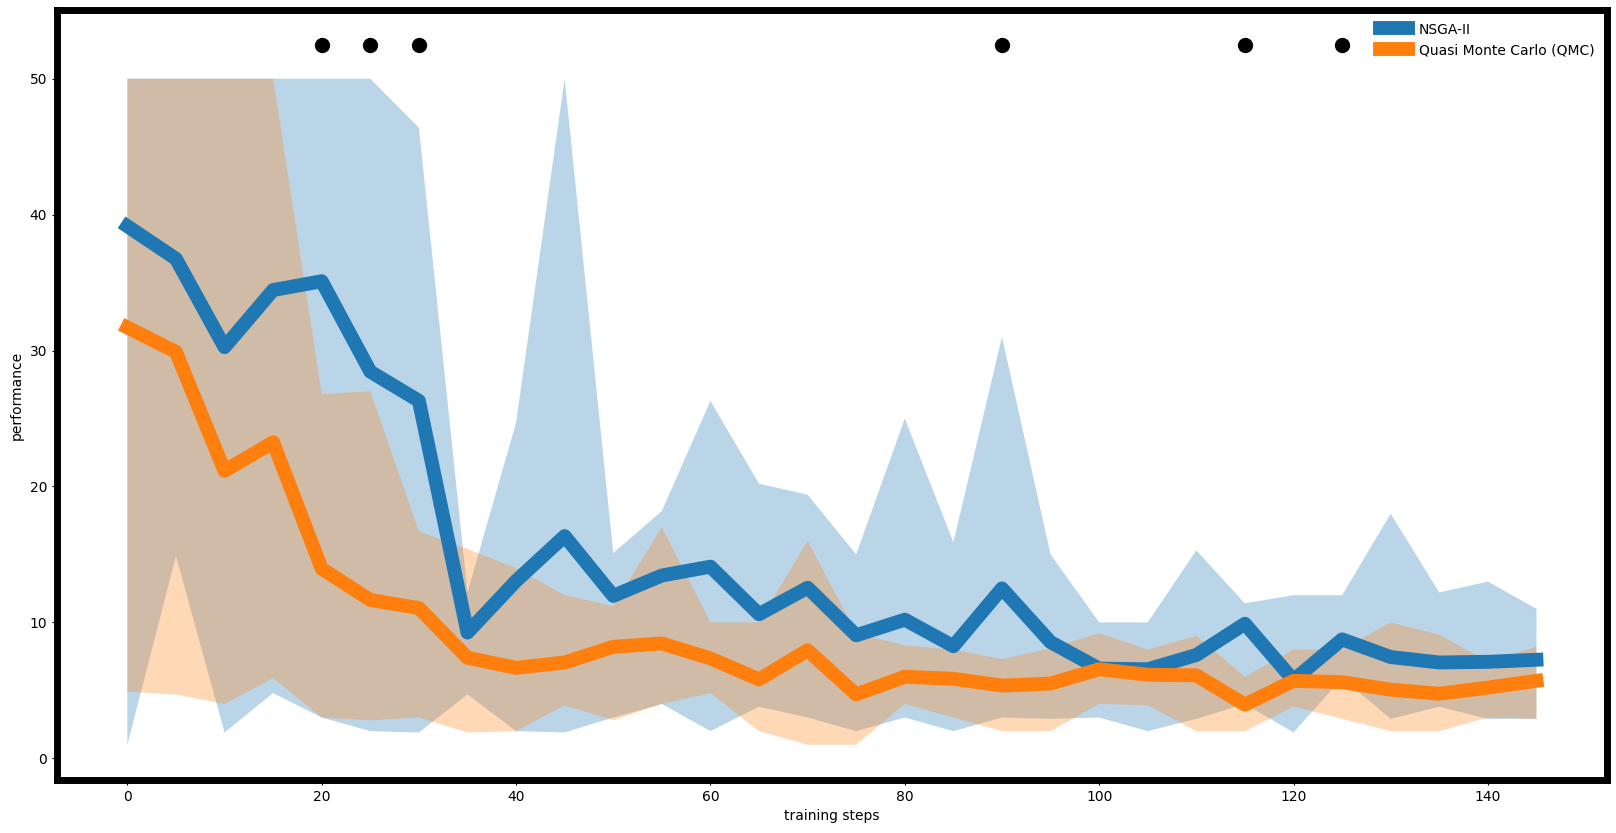

In [22]:
# Compare each pair of hyper-parameters
sampler_names = list(learning_curves.keys())

for i in range(len(sampler_names)):
    for j in range(i + 1, len(sampler_names)):
        sampler1 = sampler_names[i]
        sampler2 = sampler_names[j]

        print(f"\nComparing {sampler1} vs {sampler2}")

        # Get the learning curves for both samplers
        perf1 = learning_curves[sampler1]  # Shape: (n_runs, n_episodes)
        perf2 = learning_curves[sampler2]  # Shape: (n_runs, n_episodes)

        # Perform statistical test (Welch's t-test)
        perform_test(perf1, perf2, sampler1, sampler2, sample_size=n_runs, downsampling_fact=5, confidence_level=0.01)


# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc.